In [1]:
# Standard Library
import os
import os.path as op
import sys
import platform
import glob
import re
import shutil
import time as tm
from pathlib import Path
import pickle
import re

# Core Scientific Stack
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.signal as sgn
import scipy.stats as sts
from scipy.stats import circmean, circvar, circstd
from astropy.stats import rayleightest, vtest, circcorrcoef
from scipy.io import savemat, loadmat
from scipy.ndimage import label

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn.plotting import plot_anat
from nilearn.image import new_img_like
from scipy.ndimage import gaussian_filter1d

# MNE & BIDS
import mne
from mne import viz
from mne.viz import plot_alignment
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    write_raw_bids,
    write_anat,
    get_anat_landmarks,
    convert_montage_to_mri,
    convert_montage_to_ras,
    template_to_head,
    print_dir_tree,
    search_folder_for_text,
)
from mne_bids.stats import count_events
from mne import read_epochs
from mne.decoding import SlidingEstimator,GeneralizingEstimator

# Time-Frequency Analysis
import nitime.algorithms as tsa

# Machine Learning / Decoding
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVR, SVC
from joblib import Parallel, delayed

# Deep Learning 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Custom Toolbox
sys.path.append('/archive/intracranial/decoding_toolbox')  
import DecToolbox as dt

sys.path.append('/archive/intracranial/decoding_toolbox/Helper_funcs')
from base_stats import corr_linear_circular
from classifier_funcs import AngularRegression, SVR_polar, scorer_angle

# Other
import loess
from statsmodels.nonparametric.smoothers_lowess import lowess

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, Button, RectangleSelector, CheckButtons
import mne
from scipy import signal as sp_signal
from scipy import stats as sp_stats
import warnings
from scipy.ndimage import label
from scipy.signal import firwin, filtfilt, hilbert
from scipy.stats import median_abs_deviation as mad

2025-05-26 21:52:33.064841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 21:52:33.066919: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 21:52:33.105606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 21:52:33.130529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748289153.156947 1004476 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748289153.16

In [2]:
Exp_Modality = 'iEEG'
Exp_ID = 'EXP01'
participant = 's06'
sub_participant = f"sub-{participant}"
ID ='WAB112023C'
subject_ID =  ID + participant
session_n = '01'
task_n = 'iEEGwmprior'

In [3]:
ieeg_filename = f"{sub_participant}_ses-{session_n}_task-{task_n}_ieeg.eeg"
ieeg_filename_vhdr = f"{sub_participant}_ses-{session_n}_task-{task_n}_ieeg.vhdr"

In [4]:
sys_dir = os.path.join('/archive','intracranial') 
mne_dir = os.path.join(sys_dir,'Exp_3_WM_prior')  
data_dir = os.path.join(mne_dir , 'Raw')
bids_dir = os.path.join(mne_dir, 'raw_BIDS')
behav_dir = os.path.join(mne_dir, 'Behav', 'iEEG')
edf_path = sorted(glob.glob(os.path.join(data_dir,participant,'func','*.EDF')))  
ravecsv = os.path.join(sys_dir,'rave_data','data_dir','CLINIC_PATIENTS',ID,'rave','meta','electrodes.csv')
fsreconall_dir = os.path.join(sys_dir,'rave_data','raw_dir',ID,'rave-imaging','fs')
bids_ieeg_path = os.path.join(bids_dir, sub_participant, f"ses-{session_n}", 'ieeg',ieeg_filename)
bids_vhdr_path = os.path.join(bids_dir, sub_participant, f"ses-{session_n}", 'ieeg',ieeg_filename_vhdr)
freesurfer_path = os.path.join('/home','intracranial','freesurfer') 

# 1. Load data

In [5]:
electrodes = pd.read_csv(ravecsv)
raw = mne.io.read_raw_brainvision(bids_vhdr_path, preload=True)

Extracting parameters from /archive/intracranial/Exp_3_WM_prior/raw_BIDS/sub-s06/ses-01/ieeg/sub-s06_ses-01_task-iEEGwmprior_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 10092031  =      0.000 ...  4927.750 secs...


# 2. Events and annotations

In [6]:
events = mne.find_events(raw, stim_channel= "TRIG", output='onset')

Trigger channel TRIG has a non-zero initial value of 250 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1812 events found on stim channel TRIG
Event IDs: [ 7 39 49 97]


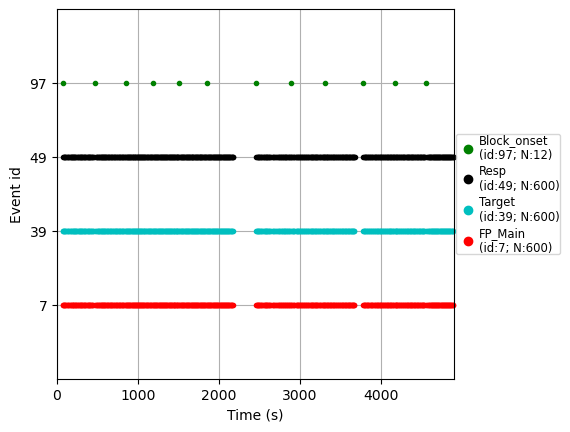

In [7]:
event_id = {'Block_onset': 97, 'FP_Main': 7, 'Target': 39,'Resp': 49}
color = {97: 'green', 7: 'red', 39: 'c', 49: 'black'}

mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id);

In [8]:
events_an = mne.annotations_from_events(events, sfreq=raw.info['sfreq'])
raw.set_annotations(events_an)

<RawBrainVision | sub-s06_ses-01_task-iEEGwmprior_ieeg.eeg, 151 x 10092032 (4927.8 s), ~11.35 GiB, data loaded>

# 3. Notch filter

In [9]:
freqs_notch = (50, 100, 150, 200)
raw.notch_filter(freqs=freqs_notch, n_jobs=6)
raw.filter(l_freq=0.2, h_freq=500, n_jobs=6)
rs_freq = 500
raw_rs = raw.resample(rs_freq, npad='auto')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:   32.7s
[Parallel(n_jobs=6)]: Done 151 out of 151 | elapsed:  1.2min finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 125.00 Hz (-6 dB cutoff frequency: 562.50 Hz)
- Filter length: 33793 samples (16.500 s)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done 151 out of 151 | elapsed:  1.2min finished


In [10]:
events_rs, event_ids = mne.events_from_annotations(raw_rs)
annotations = mne.annotations_from_events(events_rs, sfreq=raw_rs.info['sfreq'])

Used Annotations descriptions: ['39', '49', '7', '97']


# 4. Visually drop bad channels and white matter channels

In [11]:
channels_to_drop = ['MPL8', 'MPL9', 'MPL10','MPL11', 'MPL11', 'L7','L8', 'TP18', 'HP12', 'HP13', 'HP14', 'HP15','TRIG', 'TOB17', 'TOB18', 'TBP15', 'HA1', 'HA2', 'HA11', 'HA12', 'TA13', 'TA14', 'TA15', 'FMCM12', 'FMCM13', 'FMCM14', 'FMCM15', 'FMCA12']
raw_rs.drop_channels(channels_to_drop)

<RawBrainVision | sub-s06_ses-01_task-iEEGwmprior_ieeg.eeg, 124 x 2463875 (4927.8 s), ~2.28 GiB, data loaded>

In [12]:
channels_filename_tsv = f"sub-{participant}_ses-{session_n}_task-{task_n}_channels.tsv"
bids_tsv_path = os.path.join(bids_dir, f"sub-{participant}", f"ses-{session_n}", 'ieeg', channels_filename_tsv)
electrodes = pd.read_csv(bids_tsv_path, sep='\t')

fs1 = 'FSLabel_aparc_DKTatlas_aseg'
fs2 = 'FSLabel_aparc_a2009s_aseg'

mask_fs1 = electrodes[fs1].str.contains('White-Matter|WM|Unknown', 
                                        na=False, case=False)
mask_fs2 = electrodes[fs2].str.contains('White-Matter|WM|Unknown', 
                                        na=False, case=False)

bad_mask = mask_fs1 | mask_fs2

bad_chs = electrodes.loc[bad_mask, 'Label'].tolist()

raw_rs_clean = raw_rs.copy().drop_channels(
    [ch for ch in bad_chs if ch in raw_rs.ch_names]
)

# 5. Bipolar referencing

In [13]:
def bipolar_reference_seeg(raw):

    ch_names = raw.ch_names #get channel names
    electrode_groups = {} #create empty dictionary to save electrodes (keys) and contacts (values)

    for ch in ch_names: #for each channel
        prefix = ''.join(filter(str.isalpha, ch)) #Extract prefix, so for example from A1 extract A
        if prefix not in electrode_groups: #if it is not already in the dictionary, add it as a key
            electrode_groups[prefix] = []
        electrode_groups[prefix].append(ch) #add the channel in the dictionary as a value to its corresponding key

    for prefix in electrode_groups: #in this case we will sort numerically in case something went wrong and they are not ordered
        try:
            electrode_groups[prefix].sort(key=lambda x: int(''.join(filter(str.isdigit, x)))) #isdigit gets the digit from the string, and then sort will sort them out
        except ValueError: #to fix error, because we also have trig channel which does not have a number
            print(f"Skipping non-numeric channel: {electrode_groups[prefix]}")

    anodes, cathodes, bipolar_names = [], [], [] #generate empty lists that are required by the mne bipolar refer function
    for prefix, contacts in electrode_groups.items():
        contacts = [c for c in contacts if any(char.isdigit() for char in c)] 
        for i in range(len(contacts) - 1): 
            anodes.append(contacts[i])
            cathodes.append(contacts[i+1])
            bipolar_names.append(f"{contacts[i]}-{contacts[i+1]}") #name of virtual channel created after substraction

    
    raw_bipolar = mne.set_bipolar_reference(raw, anodes, cathodes, ch_name=bipolar_names, drop_refs=True) #apply function

    return raw_bipolar

Apply bipolar referencing

In [14]:
raw_rs_bipolar = bipolar_reference_seeg(raw_rs_clean)

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=84, n_times=2463875
    Range : 0 ... 2463874 =      0.000 ...  4927.748 secs
Ready.
Added the following bipolar channels:
MPL1-MPL3, MPL3-MPL4, MPL4-MPL5, MPL5-MPL6, MPL6-MPL7, L3-L4, L4-L5, L5-L6, TP1-TP2, TP2-TP3, TP3-TP10, TP10-TP11, TP11-TP12, TP12-TP13, TP13-TP14, TP14-TP15, TP15-TP16, TP16-TP17, TOB1-TOB2, TOB2-TOB3, TOB3-TOB4, TOB4-TOB5, TOB5-TOB9, TOB9-TOB10, TOB10-TOB11, TOB11-TOB12, TOB12-TOB13, TOB13-TOB14, TOB14-TOB15, TOB15-TOB16, TBP1-TBP2, TBP2-TBP3, TBP3-TBP4, TBP4-TBP5, TBP5-TBP6, TBP6-TBP7, TBP7-TBP9, TBP9-TBP10, TBP10-TBP11, TBP11-TBP12, TBP12-TBP13, TBP13-TBP14, HP1-HP2, HP2-HP4, HP4-HP5, HP5-HP6, HP6-HP7, HP7-HP8, HP8-HP9, HP9-HP10, HP10-HP11, HA3-HA7, HA7-HA8, HA8-HA9, HA9-HA10, TA1-TA2, TA2-TA3, TA3-TA4, TA4-TA5, TA5-TA8, TA8-TA9, TA9-TA10, TA10-TA11, TA11-TA12, PLT1-PLT2, PLT2-PLT3, PLT3-PLT4, PLT4-PLT5, PLT5-PLT6, PLT6-PLT7, PLT7-PLT8, PLT8-PLT9, FMCM3-FMCM4, FMCM4-FMC

Get channel names in a variable

In [15]:
channels_names = raw_rs_bipolar.ch_names

Set all channels as seeg

In [16]:
raw_rs_bipolar_fixed = raw_rs_bipolar.copy()
for idx, ch_name in enumerate(raw_rs_bipolar_fixed.ch_names):
    if ch_name != 'TRIG':  # Skip trigger channel if present
        raw_rs_bipolar_fixed.set_channel_types({ch_name: 'seeg'})

print("Channel types after fix:", {ch_type: len(mne.pick_types(raw_rs_bipolar_fixed.info, **{ch_type: True})) 
                                  for ch_type in ['seeg', 'eeg', 'misc']})

Channel types after fix: {'seeg': 84, 'eeg': 0, 'misc': 0}


# 6. Load electrode localization and set montage

Load electrode dataset and add a column with bipolar names

In [17]:
participant = 's06'

channels_filename_tsv = f"sub-{participant}_ses-{session_n}_task-{task_n}_channels.tsv"
bids_tsv_path = os.path.join(bids_dir, f"sub-{participant}", f"ses-{session_n}", 'ieeg', channels_filename_tsv)

electrodes = pd.read_csv(bids_tsv_path, sep='\t')

channels_to_drop = {
    'MPL8', 'MPL9', 'MPL10', 'MPL11',
    'L7', 'L8', 'TP18',
    'HP12', 'HP13', 'HP14', 'HP15',
    'TRIG',
    'TOB17', 'TOB18', 'TBP15',
    'HA1', 'HA2', 'HA11', 'HA12',
    'TA13', 'TA14', 'TA15',
    'FMCM12', 'FMCM13', 'FMCM14', 'FMCM15',
    'FMCA12'
}

fs1 = 'FSLabel_aparc_DKTatlas_aseg'
fs2 = 'FSLabel_aparc_a2009s_aseg'
wm_unknown_mask = (
    electrodes[fs1].str.contains('White-Matter|WM|Unknown', na=False, case=False)
  | electrodes[fs2].str.contains('White-Matter|WM|Unknown', na=False, case=False)
)

keep_mask = ~(
    electrodes['Label'].isin(channels_to_drop)
  | wm_unknown_mask
)
electrodes = electrodes[keep_mask].copy()

def extract_prefix(label):
    m = re.match(r'(.+?)(\d+)$', label.strip())
    return m.group(1) if m else label

def extract_index(label):
    m = re.match(r'.+?(\d+)$', label.strip())
    return int(m.group(1)) if m else -1

electrodes['Prefix'] = electrodes['Label'].apply(extract_prefix)
electrodes['Index']  = electrodes['Label'].apply(extract_index)
electrodes = electrodes.sort_values(['Prefix','Index']).reset_index(drop=True)

bipolar_data = []
for prefix, grp in electrodes.groupby('Prefix'):
    grp = grp.reset_index(drop=True)
    labels = grp['Label'].tolist()
    for i in range(len(labels)-1):
        e1 = grp.iloc[i]
        e2 = grp.iloc[i+1]
        bipolar_data.append({
            'Bipolar_Label': f"{labels[i]}-{labels[i+1]}",
            'x': (e1['Coord_x'] + e2['Coord_x'])/2,
            'y': (e1['Coord_y'] + e2['Coord_y'])/2,
            'z': (e1['Coord_z'] + e2['Coord_z'])/2,
            'Electrode1': labels[i],
            'Electrode2': labels[i+1],
            'Prefix': prefix
        })

bipolar_electrodes = pd.DataFrame(bipolar_data)[
    ['Bipolar_Label','x','y','z','Electrode1','Electrode2','Prefix']
]

In [18]:
rgb = np.empty((0, 4), dtype=np.int64)
label_names = {}

with open(os.path.join(freesurfer_path , 'FreeSurferColorLUT.txt'), 'r') as f:
  raw_lut = f.readlines()

pattern = re.compile(r'\d{1,5}[ ]+[a-zA-Z-_0-9*.]+[ ]+\d{1,3}[ ]+\d{1,3}[ ]+\d{1,3}[ ]+\d{1,3}')
for line in raw_lut:
  if pattern.match(line):
    s = line.rstrip().split(' ')
    s = list(filter(None, s))
    rgb = np.append(rgb, np.array([[int(s[0]), int(s[2]), int(s[3]), int(s[4])]]), axis=0)
    label_names[int(s[0])] = s[1]

In [19]:
fs_col = 'FSLabel_aparc_a2009s_aseg'  

bipolar_data = []
for prefix, grp in electrodes.groupby('Prefix'):
    grp = grp.sort_values('Index').reset_index(drop=True)
    for i in range(len(grp) - 1):
        e1, e2 = grp.iloc[i], grp.iloc[i+1]
        lab1, lab2 = e1[fs_col], e2[fs_col]
        if lab1 == lab2:
            fslabel = lab1
        else:
            fslabel = 'Mixed:' + lab1 + '|' + lab2

        bipolar_data.append({
            'Bipolar_Label': f"{e1.Label}-{e2.Label}",
            'x': (e1.Coord_x + e2.Coord_x)/2,
            'y': (e1.Coord_y + e2.Coord_y)/2,
            'z': (e1.Coord_z + e2.Coord_z)/2,
            'Electrode1': e1.Label,
            'Electrode2': e2.Label,
            'Prefix': prefix,
            'FSLabel': fslabel
        })

bipolar_electrodes = pd.DataFrame(bipolar_data,
    columns=['Bipolar_Label','x','y','z','Electrode1','Electrode2','Prefix','FSLabel'])

In [20]:
bipolar_electrodes

,Bipolar_Label,x,y,z,Electrode1,Electrode2,Prefix,FSLabel
0,FMCA4-FMCA6,33.081990,37.095990,35.226454,FMCA4,FMCA6,FMCA,Mixed:ctx_rh_S_orbital-H_Shaped|ctx_rh_S_orbit...
1,FMCA6-FMCA7,38.774869,35.723748,35.707317,FMCA6,FMCA7,FMCA,ctx_rh_S_orbital_lateral
2,FMCA7-FMCA8,41.830786,35.098716,35.740295,FMCA7,FMCA8,FMCA,Mixed:ctx_rh_S_orbital_lateral|ctx_rh_G_front_...
3,FMCA8-FMCA9,44.748171,34.459777,36.049186,FMCA8,FMCA9,FMCA,ctx_rh_G_front_inf-Orbital
4,FMCA9-FMCA10,48.470915,33.692478,36.448803,FMCA9,FMCA10,FMCA,ctx_rh_G_front_inf-Orbital
...,...,...,...,...,...,...,...,...
79,TP12-TP13,42.965079,-49.821087,31.450523,TP12,TP13,TP,ctx_rh_S_temporal_sup
80,TP13-TP14,45.603020,-49.849574,31.297167,TP13,TP14,TP,ctx_rh_S_temporal_sup
81,TP14-TP15,48.648231,-49.933098,31.255394,TP14,TP15,TP,ctx_rh_S_temporal_sup
82,TP15-TP16,52.293945,-50.024077,31.244352,TP15,TP16,TP,ctx_rh_S_temporal_sup


In [21]:
output_dir = '/archive/intracranial/Exp_3_WM_prior/analysis/bipolar_electrodes'
output_file = os.path.join(output_dir, 'bipolar_electrodes_s06prior.csv')
bipolar_electrodes.to_csv(output_file, index=False)

In [22]:
bipolar_electrodes = pd.read_csv(output_file)

In [18]:
ch_pos = {}
for _, row in bipolar_electrodes.iterrows():
    if row['Bipolar_Label'] in raw_rs_bipolar_fixed.ch_names:
        ch_pos[row['Bipolar_Label']] = np.array([row['x'], row['y'], row['z']]) / 1000.0  # convert mm to meters

custom_montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='ras')
raw_rs_bipolar_fixed.set_montage(custom_montage, on_missing='ignore')

/tmp/ipykernel_233401/3554937627.py:7: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_rs_bipolar_fixed.set_montage(custom_montage, on_missing='ignore')


<RawBrainVision | sub-s06_ses-01_task-iEEGwmprior_ieeg.eeg, 84 x 2463875 (4927.8 s), ~1.54 GiB, data loaded>

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


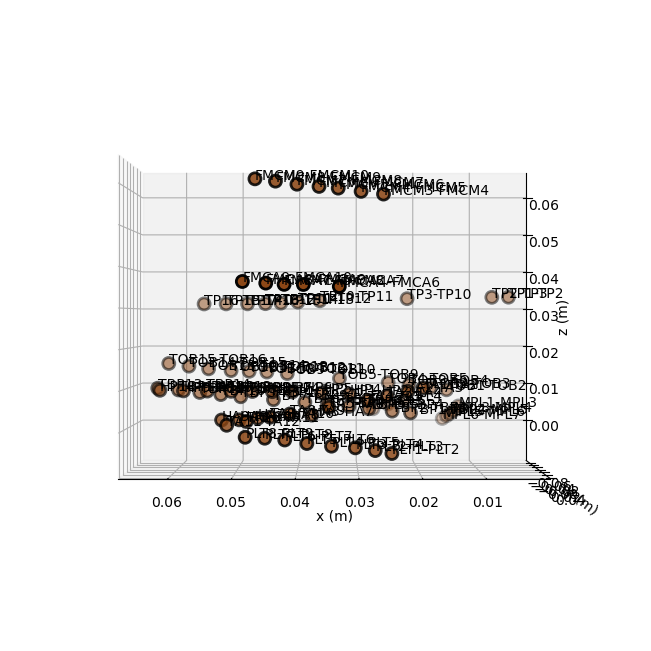

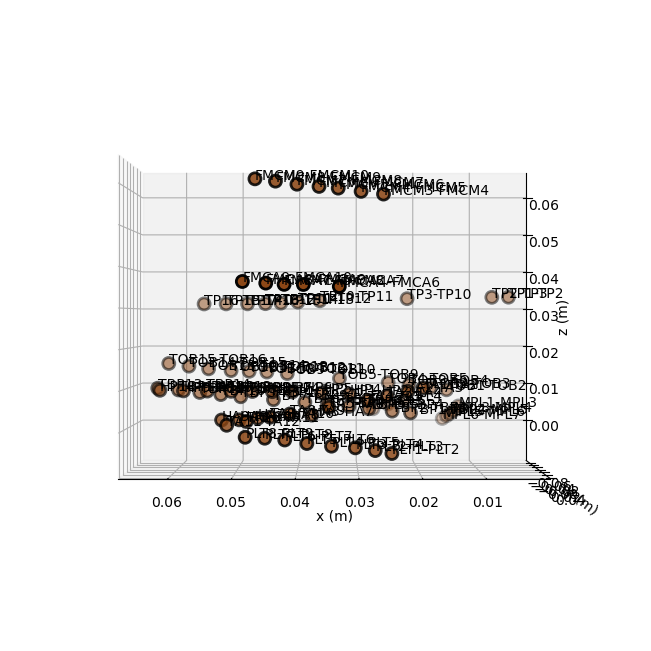

In [19]:
montaged_ch = [ch for ch in raw_rs_bipolar_fixed.ch_names if ch in ch_pos]
raw_rs_bipolar_fixed.pick_channels(montaged_ch)

raw_rs_bipolar_fixed.plot_sensors(kind='3d', show_names=True)

# Load metadata

In [5]:
import os
import pickle
import types
import pandas as pd

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Create a dummy module for psychopy
        if module.startswith("psychopy"):
            return types.SimpleNamespace
        return super().find_class(module, name)

files_to_load = ["s06_uni.psydat", "s06_notuni.psydat"]
file_paths = [os.path.join(behav_dir, file) for file in files_to_load]

all_df = pd.DataFrame([])
ddata = pd.DataFrame([])

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found!")
        continue

    subjdata = pd.DataFrame([])
    with open(file_path, "rb") as pfile:
        dat = CustomUnpickler(pfile).load()

    for block in dat.get("main_exp", {}).get("Exp_blocks", []):
        if block is None:
            continue
        
        ddata = pd.DataFrame(block["data"])
        ddata.columns = ddata.iloc[0]  
        ddata = ddata.iloc[1:, :]
        ddata.reset_index(drop=True, inplace=True)
        
        subjdata = pd.concat([subjdata, ddata], axis=0)

    all_df = pd.concat([all_df, subjdata], axis=0)

# Adjusting orientations to fall between -180 and 180
all_df["T_Angle"] = all_df["T_Angle"].astype(float)

# Removing the first trial of each block
all_df["preT"] = all_df["T_Angle"].shift(1).astype(float)
all_df["posT"] = all_df["T_Angle"].shift(-1).astype(float)
all_df["choiceAngle"] = all_df["choiceAngle"].astype(float)

mask = all_df["choiceAngle"] > 180
all_df.loc[mask, "choiceAngle"] -= 360

mask = all_df["T_Angle"] > 180
all_df.loc[mask, "T_Angle"] -= 360

all_df["keypressed"].fillna(0, inplace=True)
all_df.loc[all_df["keypressed"] == "space", "keypressed"] = 1

all_df.reset_index(drop=True, inplace=True)


/tmp/ipykernel_662777/1561960753.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["keypressed"].fillna(0, inplace=True)
/tmp/ipykernel_662777/1561960753.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["keypressed"].fillna(0, inplace=True)


In [6]:
all_df

,subj,trial,block,blocktype,prior,kappa,ct,delay,fix,keypressed,...,ts_f,ts_p,ts_d,ts_r,ts_e,m_pos_x,m_pos_y,m_clock,preT,posT
0,s06,0,0,uni,0,1,False,1000,True,0,...,1700652970.232198,1700652970.988509,1700652971.273354,1700652972.254293,1700652974.787454,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0283254012465477, 0.04857430048286915, 0.07...",NaN,49.713606
1,s06,1,0,uni,0,1,False,3000,True,0,...,1700652975.682267,1700652976.437791,1700652976.687348,1700652979.68511,1700652982.368935,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.002781299874186516, 0.020566200837492943, 0...",108.440105,123.057117
2,s06,2,0,uni,0,1,False,3000,True,0,...,1700652983.182193,1700652983.938423,1700652984.186211,1700652987.184678,1700652990.018254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004024000838398933, 0.019258201122283936, 0...",49.713606,51.669873
3,s06,3,0,uni,0,1,False,1000,True,0,...,1700652990.815259,1700652991.569685,1700652991.819998,1700652992.801392,1700652996.485883,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.003924200311303139, 0.02003839984536171, 0....",123.057117,-139.116314
4,s06,4,0,uni,0,1,False,1000,True,0,...,1700652997.18347,1700652997.937184,1700652998.18772,1700652999.171081,1700653004.100211,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005066500976681709, 0.029792601242661476, 0...",51.669873,-169.483005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,s06,45,5,notuni,-170.4,1,False,3000,True,0,...,1700670120.802183,1700670121.558944,1700670121.808295,1700670124.826585,1700670128.007733,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005134100094437599, 0.029332099482417107, 0...",-126.468145,-141.980293
596,s06,46,5,notuni,-170.4,1,False,3000,True,0,...,1700670128.801405,1700670129.557542,1700670129.80946,1700670132.806253,1700670134.589362,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0036414004862308502, 0.018116001039743423, ...",-140.603741,170.638381
597,s06,47,5,notuni,-170.4,1,False,1000,True,0,...,1700670135.450895,1700670136.209194,1700670136.458221,1700670137.457528,1700670141.524202,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004711000248789787, 0.030330998823046684, 0...",-141.980293,-144.703918
598,s06,48,5,notuni,-170.4,1,False,1000,True,0,...,1700670142.284998,1700670143.042167,1700670143.291211,1700670144.275063,1700670150.035645,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005602400749921799, 0.030047601088881493, 0...",170.638381,-117.126872


## Get Raw Epochs and manually drop bad channels

In [43]:
my_event_id = {'FP_Main': event_ids['7']}

epochs_raw = mne.Epochs(
    raw_rs_bipolar_fixed,
    events_rs,
    event_id=my_event_id,
    tmin=-1.5,
    tmax=4.5,
    preload=True,
    verbose=True
)

Not setting metadata
600 matching events found
Setting baseline interval to [-1.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 600 events and 3001 original time points ...


0 bad epochs dropped


In [44]:
epochs_raw.metadata = all_df

Adding metadata with 31 columns


In [25]:
preproc_dir = os.path.join(mne_dir,'Preproc',participant)  
epochs_raw_uncleaned_path = os.path.join(preproc_dir, "epochs_raw_uncleaned_s06prior-epo.fif")
epochs_raw.save(epochs_raw_uncleaned_path, overwrite=True)

[PosixPath('/archive/intracranial/Exp_3_WM_prior/Preproc/s06/epochs_raw_uncleaned_s06prior-epo.fif')]

In [45]:
final_rejected_channel_names_raw = ['HP10-HP11', 'L5-L6']
final_rejected_trial_indices_raw = [32, 60, 92, 98, 242, 252, 254]

In [46]:
epochs_raw.drop_channels(final_rejected_channel_names_raw)
n_epochs = len(epochs_raw)
all_idx  = np.arange(n_epochs)
keep_idx = np.setdiff1d(all_idx, final_rejected_trial_indices_raw)

epochs_raw_clean = epochs_raw[keep_idx]

In [47]:
preproc_dir = os.path.join(mne_dir,'Preproc',participant)  
epochs_raw_clean_path = os.path.join(preproc_dir, "epochs_raw_clean_s06prior-epo.fif")
epochs_raw_clean.save(epochs_raw_clean_path, overwrite=True)

[PosixPath('/archive/intracranial/Exp_3_WM_prior/Preproc/s06/epochs_raw_clean_s06prior-epo.fif')]

# 7. Automated Artifact Detection

#### Padding function

In the last function of this 4, 'artifact detection' artifacts will be marked in binary.\
\
    0 → No artifact detected (clean EEG data)\
    1 → Artifact detected (bad EEG segment)

The objective of 'padding' is to expand clusters of 1s in binary arrays by adding padding before and after each cluster. So that if an artifact is detected at a certain time, it will include some buffer. So basically we are expanding the artifact length, this is because EEG artifacts may affect nearby samples, even if they aren't directly marked as bad, by expanding 1s, we make sure these "borderline" areas are removed too.

In [20]:
def padding(data, padding_value): # Binary vector where 1 indicates an artifact. padding_value: an integer indicating how many samples before and after a detected artifact should be added.

    labeled_array, num_features = label(data) #this gets the clusters of 1s, in labeled_array each cluster of 1s gets a unique label and num_features saves the total number of clusters detected.
    
    if num_features > 0:
        for i in range(1, num_features + 1):
            clust = np.where(labeled_array == i)[0] #np.where gets indices, clust is an array of indices where that cluster of 1s is located.
            
            # Left padding (before the artifact)
            if clust[0] - padding_value >= 0:  # Can pad left
                data[clust[0] - padding_value : clust[0]] = 1
            
            # Right padding (starting at last artifact sample)
            if clust[-1] + padding_value < len(data):  # Can pad right
                data[clust[-1] : clust[-1] + padding_value] = 1
    
    return data

#### Remove small segments

'remove_small_segments' removes small segments of zeros in a binary array by converting them to ones.\
\
    data (numpy array): 1D binary array.\
    min_seg_length (int): Minimum segment length to keep.\
    \
Sometimes, very short clean segments (0s) may appear between artifacts due to noise or brief signal recovery. This function removes clean segments that are too short by converting them to artifact markers (1s). It removes false positives.


In [21]:
def remove_small_segments(data, min_seg_length):
    
    mks = ~data.astype(bool)  #invert data --> 1s -> 0s (artifacts become non-artifacts) and 0s -> 1s (non-artifact regions become potential candidates for removal).
    # data.astype(bool): Converts 0 → False, 1 → True, ~ (bitwise NOT): Inverts the boolean array
    labeled_array, num_features = label(mks)  #identify connected components of 0s

    if num_features > 0:
        segment_sizes = np.bincount(labeled_array.flat)[1:]  #compute size of each segment.
        small_segments = np.where(segment_sizes < min_seg_length)[0] + 1  #any segment smaller than min_seg_length is converted to 1s.

        for seg in small_segments:
            data[labeled_array == seg] = 1 

    return data

#### Eegfilt

This function applies bandpass, lowpass, or highpass filtering to EEG data using FIR (Finite Impulse Response) filters.\
\
If only hicutoff is provided → Low-pass filter (removes high frequencies).\
If only locutoff is provided → High-pass filter (removes low frequencies).\
If both are provided → Bandpass filter (keeps only certain frequencies).\
If revfilt=1 → Band-stop filter (removes a specific frequency range).\
\
firwin() → Creates the FIR filter coefficients.\
filtfilt() → Applies zero-phase filtering (avoids phase distortion).

In [22]:
def eegfilt(data, srate, locutoff=None, hicutoff=None, epochframes=0, filtorder=None, revfilt=0): # epochframes: How many frames per segment to filter (default 0 = full trace)
    chans, frames = data.shape
    nyq = srate * 0.5
    minfac = 3 # Filter Order Scaling Factor: This is a scaling factor used to calculate the initial filter order based on the sampling rate and the cutoff frequency.
    # If minfac is too small: The filter will be too short → poor frequency separation
    # If minfac is too large: The filter will be too long → more computation time, needs more padding...
    min_filtorder = 15 # Minimum Filter Order: This is the minimum order of the filter. If the calculated filter order is less than this value, it will be set to this value.
    trans = 0.15 # It controls the width of the transition band in the filter design, it affects how “sharp” the cutoff is.

    if locutoff is not None and hicutoff is not None and locutoff > hicutoff:
        raise ValueError("locutoff must be <= hicutoff.")
    if (locutoff is not None and locutoff < 0) or (hicutoff is not None and hicutoff < 0):
        raise ValueError("Cutoff frequencies must be non-negative.")
    if (locutoff is not None and locutoff >= nyq) or (hicutoff is not None and hicutoff >= nyq):
        raise ValueError("Cutoff frequencies must be less than Nyquist.")

    if filtorder is None:
        if locutoff is not None:
            filtorder = minfac * int(srate / locutoff)
        elif hicutoff is not None:
            filtorder = minfac * int(srate / hicutoff)
        filtorder = max(filtorder, min_filtorder)

    # FIR filters, especially with filtfilt, which applies the filter forward and backward, need a buffer of data around the edges to function properly.
    # Here we manage data segmentation to fix that.

    if epochframes == 0: # If epochframes isn't provided, filter the entire time series as a single chunk.
        epochframes = frames # frames is the total number of timepoints in the signal. If epochframes is 0, it means we want to filter the entire signal as a whole chunk.
    epochs = frames // epochframes # Each epoch must be ≥ 3 × filter order (to avoid edge effects during filtering). This computes how many equal-sized segments we’ll divide the signal into.
    if epochs * epochframes != frames: # Ensures that the signal can be perfectly divided into chunks.
        raise ValueError("epochframes does not evenly divide frames.")
    if filtorder * 3 > epochframes: # FIR filters require enough padding to operate properly, and when using filtfilt, zero-phase filtering, the data is mirrored around the edges.
    # the segment should be at least 3× the filter length to allow proper padding, filtering.
        raise ValueError("epochframes must be at least 3 times the filtorder.")

    # Design a Finite Impulse Response (FIR) filter
    if locutoff is not None and hicutoff is not None:
        bands = [0, locutoff * (1 - trans), locutoff, hicutoff, hicutoff * (1 + trans), nyq] #The bands array defines points in frequency space.
        desired = [0, 0, 1, 1, 0, 0] # The desired array defines the desired amplitude response of the filter at each of those points.
        # trans defines a small slope for the transition band so that the filter is practical to implement.
        cutoff = [bands[2], bands[3]]  # Passband
    elif locutoff is not None:
        bands = [0, locutoff * (1 - trans), locutoff, nyq]
        desired = [0, 0, 1, 1]
        cutoff = [bands[2]]
    elif hicutoff is not None:
        bands = [0, hicutoff, hicutoff * (1 + trans), nyq]
        desired = [1, 1, 0, 0]
        cutoff = [bands[1]]
    else:
        raise ValueError("You must provide a non-zero low or high cutoff frequency.")

    if revfilt:
        desired = [1 - d for d in desired]

    # Normalize cutoff(s)
    normalized_cutoff = [c / nyq for c in cutoff] # firwin expects cutoff frequencies in the range of 0.0 to 1.0 (as a fraction of the Nyquist frequency)
    filtwts = firwin(filtorder + 1, normalized_cutoff, pass_zero=desired[0] == 1) # filtwts array contains the filter kernel

    # Apply filter
    smoothdata = np.zeros_like(data) # empty array of the same shape as the input to store the filtered signal.
    for e in range(epochs):
        for c in range(chans):
            segment = data[c, e * epochframes:(e + 1) * epochframes]
            smoothdata[c, e * epochframes:(e + 1) * epochframes] = filtfilt(filtwts, 1, segment) # filtfilt applies the filter forward and backward to avoid phase distortion. 1 is de denominator of the filter transfer function, which is 1 for FIR filters.

    return smoothdata, filtwts


#### Artifact detection

The following function detects artifacts in EEG data by checking:\
\
Amplitude deviations (Z-score thresholding)\
Gradient changes\
High-pass filtered envelope fluctuations (via Hilbert transform)\
Padding & segment filtering\

Artifacts are replaced with NaN values.

1. eegfilt() – applies FIR filters
2. hilbert() + data amplitude and gradient 
3. artifact_detection() – combines amplitude, gradient, and envelope-based Z-scores to detect artifacts
4. padding() 
5. remove_small_segments()

In [23]:
def artifact_detection(data, std_thres, std_thres2, padding_value, min_seg_length):
    data_clean = np.copy(data)

    for chani in range(data.shape[0]): #Iterates over each EEG channel.
        channel_data = data[chani, :] #Extracts a single-channel time series

        #now it will calculate the z-score, large values indicate outliers

        z_score_amp = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        grad = np.diff(channel_data, append=np.nan) #Computes first derivative
        z_score_grad = (grad - np.nanmean(grad)) / np.nanstd(grad) #Normalizes it using Z-score transformation.

        #Ensure data is 2D for eegfilt function

        if channel_data.ndim == 1:
            channel_data = channel_data[np.newaxis, :]  #Reshape to (1, samples)

        hpf_data, _ = eegfilt(channel_data, 500, None, 249)
        hpf_data = np.abs(hilbert(hpf_data))
        z_score_hpf_d = (hpf_data - np.mean(hpf_data)) / np.std(hpf_data)

        markers = np.zeros_like(channel_data) #create array of 0s
        condition1 = (z_score_amp > std_thres) | (z_score_grad > std_thres) | (z_score_hpf_d > std_thres)
        condition2 = (z_score_amp > std_thres2) & ((z_score_grad > std_thres2) | (z_score_hpf_d > std_thres2))
        markers[condition1 | condition2] = 1 #mark artifact locations as 1s

        new_trace = padding(markers, padding_value)  
        markers = remove_small_segments(new_trace, min_seg_length)  

        data_clean[chani, markers.flatten() == 1] = np.nan #Replaces artifact samples with NaN

    return data_clean


In [24]:
def artifact_detection_tuned(
    data, # 2D array: (n_channels, n_samples)
    amp_thr, # amplitude threshold in MAD‐units
    grad_thr, # gradient threshold in MAD‐units     
    hpf_thr,  # high-frequency envelope threshold in MAD‐units     
    min_art_sec,   # 0.005  → 5 ms minimum artifact duration, minimum artifact run length in seconds
    pad_samps,     # number of samples to pad around each artifact cluster
    fill_gap_sec,  # 0.02   → fill any clean gap ≤20 ms, maximum clean-gap length in seconds to “fill” 
    overshoot_fac=1.3,  # keep VERY large spikes even if short, allow any cluster with a peak > amp_thr × overshoot_fac to survive even if very short
    sfreq=500
):

    nchan, nsamp = data.shape
    out = data.copy()
    min_art = int(min_art_sec  * sfreq)
    fill_gap = int(fill_gap_sec * sfreq)
    
    for ch in range(nchan):
        x = data[ch]

        # Median (med_x) and MAD (mad_x) replace mean/std
        med_x   = np.median(x)
        mad_x   = mad(x, scale='normal')
        z_amp   = (x - med_x) / mad_x
        
        # First derivative via np.diff, then median/MAD normalization. Sharp edges (steep slopes) show up as large z_grad.
        grad    = np.diff(x, append=x[-1])
        med_g   = np.median(grad)
        mad_g   = mad(grad, scale='normal')
        z_grad  = (grad - med_g) / mad_g
        
        hpf, _  = eegfilt(x[np.newaxis,:], sfreq, None, 240)
        env     = np.abs(hilbert(hpf)).flatten()
        med_h   = np.median(env)
        mad_h   = mad(env, scale='normal')
        z_hpf   = (env - med_h) / mad_h
        
        # A sample is flagged if any one of the three metrics crosses its own threshold.
        mask0 = (
              (z_amp  > amp_thr) # Anything where z_amp > amp_thr is a heavy outlier in raw amplitude.
            | (z_grad > grad_thr)
            | (z_hpf  > hpf_thr)
        ).astype(int)
        
        
        labeled, nseg = label(mask0) # label finds each contiguous run (cluster) of 1’s in mask0.
        for seg_id in range(1, nseg+1): # For each cluster, we check: Length, if shorter than min_art samples, and peak amplitude (max_z), also below a “giant‐spike” cutoff (amp_thr × overshoot_fac).
            idx = np.where(labeled==seg_id)[0]
            max_z = max(z_amp[idx].max(),
                        z_grad[idx].max(),
                        z_hpf[idx].max())
            
            if idx.size < min_art and max_z < amp_thr * overshoot_fac:
                mask0[idx] = 0
        
        # In effect, we drop short, small sized clusters, but keep any cluster that’s either long enough or truly huge.
        
        mask1 = padding(mask0, pad_samps) # extend every flagged cluster by pad_samps on both sides ensuring we capture pre and post artifact effects.
        
        mask2 = remove_small_segments(mask1, fill_gap) # This is the opposite of the previous prune, here we fill any clean stretch shorter than fill_gap.
        # It ensures that we don’t leave tiny holes of NaNs inside a broader artifact region, so artifacts appear as solid blocks.
        
        out[ch, mask2==1] = np.nan
    
    return out


Main differences with original artifact detection algorithm: 

1. Use of median +/- MAD.
2. Separate thresholding.
3. In the original version we had to thresholds, the first more permisive one with one condition in three needed to be complied, and a stricter one with an AND for conditioning. In the new version the first condition remains as an OR so one in three at least has to happen, but independent cutoffs are applied (as if it is too short, or it is a clear short segment high amplitude peak).
4. Small-artifact handling plays a big difference too. In the first version we either filled clean gaps or cleared short artifacts. In the newer version both are carried out: first clear short clusters, then fill tiny gaps
5. Robstuness is quite different too, and is related with the first change, std is quite sensitive to outliers, instead median/MAD remain unaffected by extreme values.


In [25]:
data = raw_rs_bipolar_fixed.get_data()
sfreq = raw_rs_bipolar_fixed.info['sfreq'] 

Define parameters

In [26]:
amp_thr     = 14.0   
grad_thr    = 11.0   
hpf_thr     = 11.0     
min_art_sec = 0.08  # 40 ms minimum artifact duration
pad_samps = int(sfreq * 0.05)  # 25 ms padding
fill_gap_sec = 0.1  # fill any clean gap ≤50 ms

data_clean = artifact_detection_tuned(
    data,
    amp_thr,       
    grad_thr,     
    hpf_thr,      
    min_art_sec,   
    pad_samps,     
    fill_gap_sec,  
    overshoot_fac=1.3,  
    sfreq=500
)

In [27]:
preproc_dir = os.path.join(mne_dir,'Preproc',participant)  
data_clean_path = os.path.join(preproc_dir, "data_clean.npy")
np.save(data_clean_path, data_clean)

In [86]:
preproc_dir = os.path.join(mne_dir,'Preproc',participant)  
data_clean_path = os.path.join(preproc_dir, "data_clean.npy")
data_clean = np.load(data_clean_path)

In [28]:
def convert_to_mne(data_clean, raw_template):

    ch_names = raw_template.ch_names
    sfreq = raw_template.info['sfreq']
    
    # Assign 'seeg' to all channels except for the trigger channel
    ch_types = ['stim' if 'trig' in ch.lower() else 'seeg' for ch in ch_names]
    
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw_clean = mne.io.RawArray(data_clean, info)
    
    return raw_clean

In [29]:
raw_clean = convert_to_mne(data_clean, raw_rs_bipolar_fixed)

Creating RawArray with float64 data, n_channels=84, n_times=2463875
    Range : 0 ... 2463874 =      0.000 ...  4927.748 secs
Ready.


Set annotations again since mne -> npy and npy -> mne gets rid of them

In [30]:
raw_clean.set_annotations(mne.annotations_from_events(events_rs, sfreq=raw_clean.info['sfreq']))

<RawArray | 84 x 2463875 (4927.8 s), ~1.54 GiB, data loaded>

In [31]:
raw_clean.set_annotations(raw_rs_bipolar.annotations)

<RawArray | 84 x 2463875 (4927.8 s), ~1.54 GiB, data loaded>

In [32]:
events_clean, event_ids = mne.events_from_annotations(raw_clean)

Used Annotations descriptions: ['39', '49', '7', '97']


start=2500, picks=['HP6-HP7','HP8-HP9','HP9-HP10']
start=2450, picks=['PLT1-PLT2','PLT3-PLT4','PLT5-PLT6''FMCM3-FMCM4','FMCM4-FMCM5','HP8-HP9','HP9-HP10','L3-L4''L4-L5''MPL1-MPL3','MPL3-MPL4','MPL4-MPL5']
start=2415, picks=['HP1-HP2','HP2-HP4','HP5-HP6''HP6-HP7','HP7-HP8','HP8-HP9','HP9-HP10','HP10-HP11']

In [ ]:
raw_rs_bipolar.plot(start=2415, picks=slice(40,60), scalings=1e-4)
raw_clean.plot(start=2415, picks=slice(40,60), scalings=1e-4)

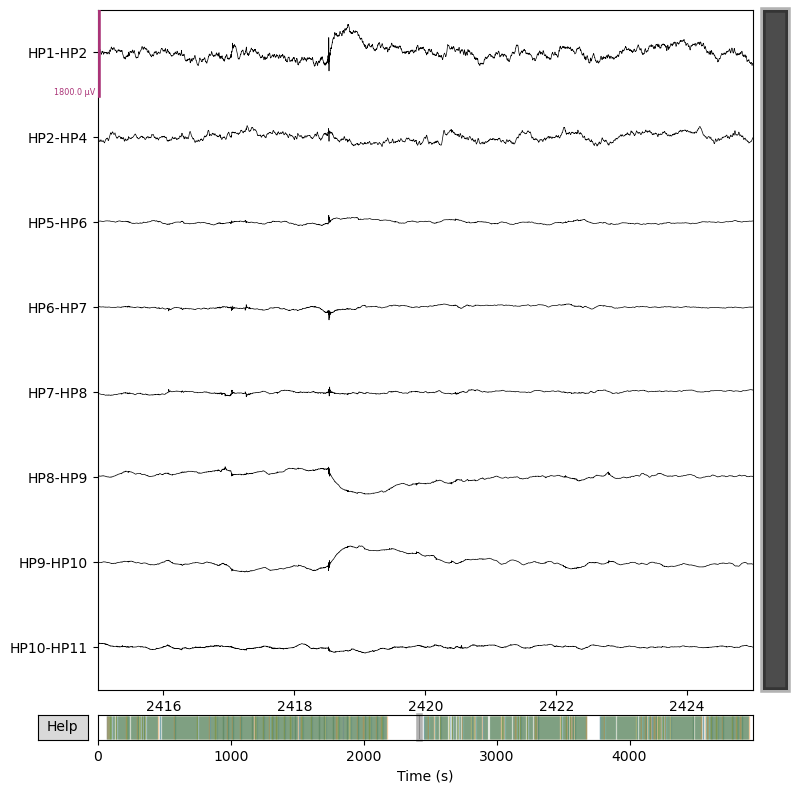

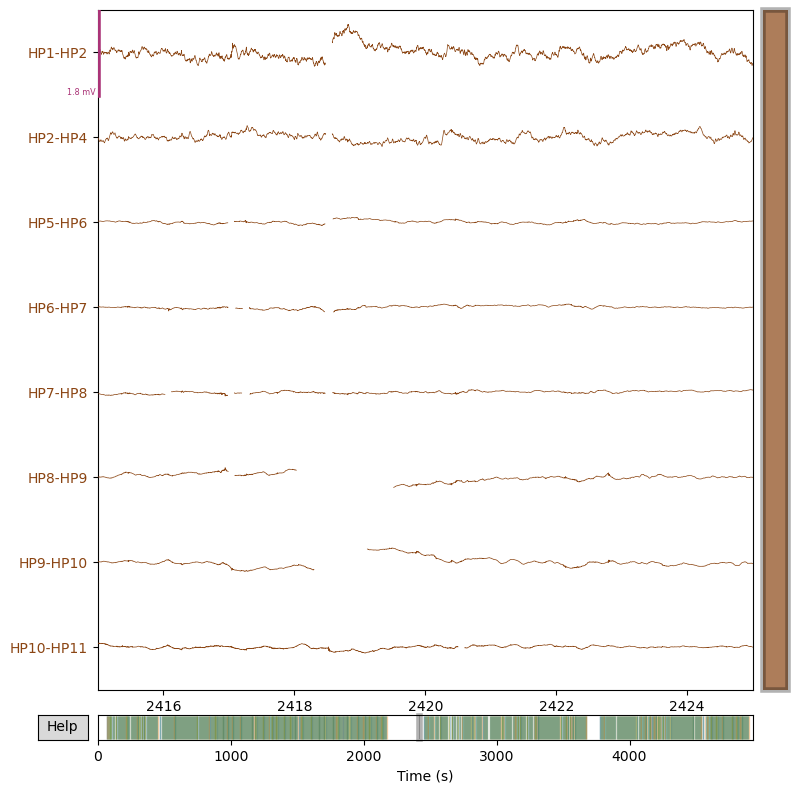

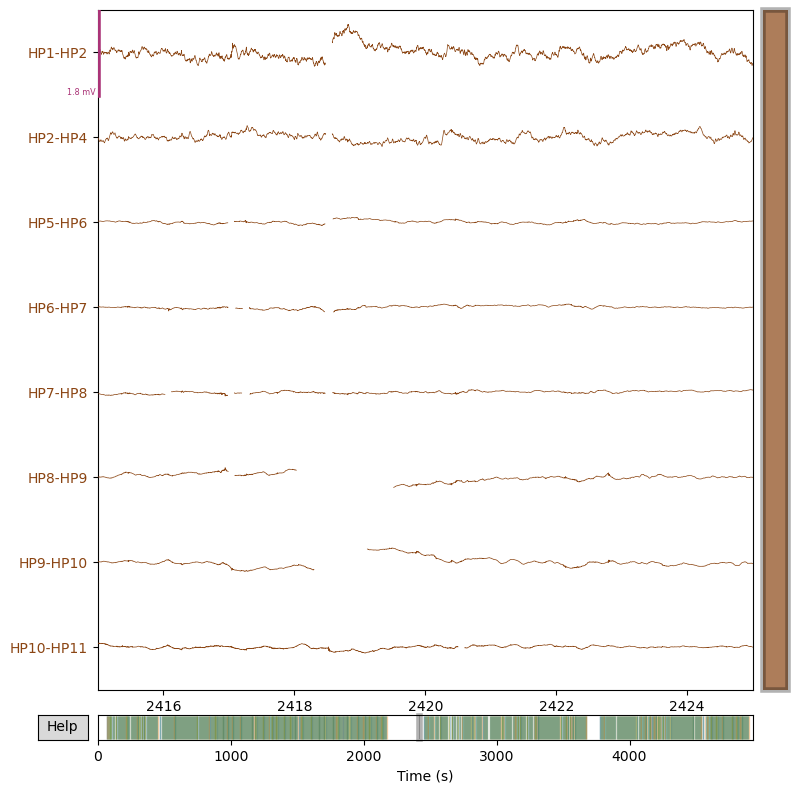

In [81]:
raw_rs_bipolar.plot(start=2415, picks=['HP1-HP2','HP2-HP4','HP5-HP6','HP6-HP7','HP7-HP8','HP8-HP9','HP9-HP10','HP10-HP11'], scalings=9*1e-4)
raw_clean.plot(start=2415, picks=['HP1-HP2','HP2-HP4','HP5-HP6','HP6-HP7','HP7-HP8','HP8-HP9','HP9-HP10','HP10-HP11'], scalings=9*1e-4)

# Get EPOCHS

In [61]:
my_event_id = {'FP_Main': event_ids['7']}

epochs = mne.Epochs(
    raw_clean,
    events_clean,
    event_id=my_event_id,
    tmin=-1.5,
    tmax=4.5,
    preload=True,
    verbose=True
)

Not setting metadata
600 matching events found
Setting baseline interval to [-1.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 600 events and 3001 original time points ...


0 bad epochs dropped


In [62]:
epochs.metadata = all_df

Adding metadata with 31 columns


In [88]:
epochs_path = os.path.join(preproc_dir, "epochs_s06prior_uncleaned-epo.fif")
epochs.save(epochs_path, overwrite=True)

Overwriting existing file.


Overwriting existing file.


[PosixPath('/archive/intracranial/Exp_3_WM_prior/Preproc/s06/epochs_s06prior_uncleaned-epo.fif')]

In [89]:
original_selection = epochs.selection
print(f"Original selection indices: {len(original_selection)}")

Original selection indices: 300


In [365]:
preproc_dir = os.path.join(mne_dir,'Preproc',participant)  
epochs_path = os.path.join(preproc_dir, "epochs_s06prior-epo.fif")
epochs = mne.read_epochs(epochs_path)

Reading /archive/intracranial/Exp_3_WM_prior/Preproc/s06/epochs_s06prior-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    4500.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated


# Visual Reject

In [105]:
try:
    from autoreject import RejectLog
except ImportError:
    RejectLog = None 

def calculate_metric(data_in, metric='var'):
   
    found_nans = False

    with np.errstate(invalid='ignore'):

        if np.isnan(data_in).any():
            found_nans = True

    n_epochs, n_channels, n_times = data_in.shape
    # Initialize metric_data with NaNs, so if a calculation fails or is skipped, NaN remains.
    metric_data = np.full((n_channels, n_epochs), np.nan)

    # Suppress RuntimeWarnings locally for nan-aware functions if they still emit them
    # (e.g. "Degrees of freedom <= 0 for slice"" in nanvar/nanstd for all-NaN slices)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i_chan in range(n_channels):
            chan_data = data_in[:, i_chan, :] # Shape: (n_epochs, n_times)

            if metric == 'var':
                metric_data[i_chan, :] = np.nanvar(chan_data, axis=1)
            elif metric == 'std':
                metric_data[i_chan, :] = np.nanstd(chan_data, axis=1)
            elif metric == 'mad':
                try:
                    # SciPy >= 1.7.0 has nan_policy for median_abs_deviation
                    metric_data[i_chan, :] = sp_stats.median_abs_deviation(
                        chan_data, axis=1, scale='normal', nan_policy='omit'
                    )
                except TypeError:
                    # Fallback for older SciPy versions
                    warnings.warn(
                        "SciPy version < 1.7.0 detected."
                        "MAD calculation cannot ignore NaNs natively via 'nan_policy'. "
                        "Manually skipping NaNs. Result may be NaN if all data in an epoch is NaN.",
                        RuntimeWarning, stacklevel=2
                    )
                    for i_epoch in range(n_epochs):
                        epoch_data = chan_data[i_epoch, :]
                        if np.all(np.isnan(epoch_data)):
                            metric_data[i_chan, i_epoch] = np.nan
                            continue
                        metric_data[i_chan, i_epoch] = sp_stats.median_abs_deviation(
                            epoch_data[~np.isnan(epoch_data)], scale='normal'
                        )
            elif metric == '1/var':
                variances = np.nanvar(chan_data, axis=1)
                # Add epsilon to variance to prevent division by zero, then compute inverse
                variances[variances == 0] = np.finfo(float).eps
                metric_data[i_chan, :] = 1.0 / variances
            elif metric == 'min':
                metric_data[i_chan, :] = np.nanmin(chan_data, axis=1)
            elif metric == 'max':
                metric_data[i_chan, :] = np.nanmax(chan_data, axis=1)
            elif metric == 'maxabs':
                metric_data[i_chan, :] = np.nanmax(np.abs(chan_data), axis=1)
            elif metric in ['range', 'ptp']: # Peak-to-peak
                max_vals = np.nanmax(chan_data, axis=1)
                min_vals = np.nanmin(chan_data, axis=1)
                metric_data[i_chan, :] = max_vals - min_vals
            elif metric == 'kurtosis':
                try:
                    # SciPy >= 0.19.0 has nan_policy for kurtosis
                    metric_data[i_chan, :] = sp_stats.kurtosis(
                        chan_data, axis=1, nan_policy='omit'
                    )
                except TypeError:
                    # Fallback for older SciPy versions
                    warnings.warn(
                        "Kurtosis calculation cannot ignore NaNs natively via 'nan_policy'."
                        "Manually skipping NaNs. Result may be NaN if all data in an epoch is NaN.",
                        RuntimeWarning, stacklevel=2
                    )
                    for i_epoch in range(n_epochs):
                        epoch_data = chan_data[i_epoch, :]
                        if np.all(np.isnan(epoch_data)):
                            metric_data[i_chan, i_epoch] = np.nan
                            continue
                        metric_data[i_chan, i_epoch] = sp_stats.kurtosis(
                            epoch_data[~np.isnan(epoch_data)]
                        )
            else:
                # Metric not implemented
                warnings.warn(f"Metric '{metric}' not implemented.", UserWarning, stacklevel=2)
                return None, found_nans # Return None for metric_data

    return metric_data, found_nans

def reject_visual_mne(epochs, metric='var', sfreq=None):

    if not isinstance(epochs, mne.BaseEpochs):
        raise TypeError("Input must be an MNE Epochs object.")

    data = epochs.get_data(picks=['eeg', 'meg', 'ecog', 'seeg'])
    if data is None or data.size == 0:
        warnings.warn("No data found for EEG, MEG, ECoG, or SEEG channels. Returning empty selections.", UserWarning)
        return [], []

    n_epochs, n_channels, n_times = data.shape
    ch_names = epochs.copy().pick_types(eeg=True, meg=True, ecog=True, seeg=True).ch_names # Ensure ch_names match data

    if sfreq is None:
        sfreq = epochs.info['sfreq']

    current_metric = metric
    rejected_trials = set()  # Store indices of rejected trials
    rejected_channels_idx = set()  # Store indices of rejected channels
    bad_channel_names = set() # Store names of rejected channels for final output
    calculate_spectrum = True # Flag to control spectrum calculation and display
    _nan_warning_issued = False # Flag to ensure NaN warning is shown only once

    plot_elements = {}  # Dictionary to store matplotlib artists for easy access/update
    selectors = {}      # Dictionary to store RectangleSelector objects

    def _calculate_metric_and_warn(data_to_calc, metric_name):
        nonlocal _nan_warning_issued
        metric_res, found_nans = calculate_metric(data_to_calc, metric_name)
        if found_nans and not _nan_warning_issued:
            warnings.warn(
                "Input data contains NaNs. Metrics will be calculated ignoring NaNs. "
                "Resulting metrics may be NaN if all data points for a specific "
                "channel/epoch calculation are NaN.",
                RuntimeWarning, stacklevel=3 # Adjust stacklevel as needed
            )
            _nan_warning_issued = True # Set flag after the first warning
        return metric_res

    # Initial metric calculation
    metric_data = _calculate_metric_and_warn(data, current_metric)
    if metric_data is None: # Handle invalid initial metric
        warnings.warn(
            f"Initial metric '{current_metric}' is invalid or calculation failed. Defaulting to 'var'.",
            UserWarning
        )
        current_metric = 'var'
        metric_data = _calculate_metric_and_warn(data, current_metric)
        if metric_data is None:
            raise ValueError("Could not calculate the default 'var' metric. Check input data.")

    if np.all(np.isnan(metric_data)):
         warnings.warn(
             "Initial metric calculation resulted in all NaNs. "
             "Check input data or the chosen metric. The visualization might be uninformative.",
             RuntimeWarning, stacklevel=2
         )

    fig = plt.figure(figsize=(12, 8.5))
    gs = fig.add_gridspec(
        4, 3, width_ratios=[3, 2, 1.5], height_ratios=[2, 2, 0.7, 0.4],
        hspace=0.4, wspace=0.3 # Added wspace for better default layout
    )
    ax_summary = fig.add_subplot(gs[0, 0])          # Heatmap of metric_data
    ax_chan_summary = fig.add_subplot(gs[0, 1], sharey=ax_summary) # Channel means
    ax_trial_summary = fig.add_subplot(gs[1, 0], sharex=ax_summary) # Trial means
    ax_spectrum = fig.add_subplot(gs[1, 1])         # Average spectrum
    ax_controls = fig.add_subplot(gs[0:2, 2])       # Text info and status
    ax_metric_radio = fig.add_subplot(gs[2, 0])     # Radio buttons for metric selection
    ax_spec_check = fig.add_subplot(gs[2, 1])       # Checkbox for spectrum toggle
    ax_quit_button = fig.add_subplot(gs[3, 2])      # Quit button

    # Configure axes appearance
    plt.setp(ax_chan_summary.get_yticklabels(), visible=False)
    plt.setp(ax_trial_summary.get_xticklabels(), visible=False)
    ax_controls.axis('off') # No ticks or frame for the controls panel

    def update_spectrum_plot():

        ax_spectrum.clear()
        if calculate_spectrum:
            good_trials_idx = sorted(list(set(range(n_epochs)) - rejected_trials))
            good_channels_idx = sorted(list(set(range(n_channels)) - rejected_channels_idx))

            if not good_trials_idx or not good_channels_idx:
                ax_spectrum.text(0.5, 0.5, 'No good data selected\nfor spectrum',
                                 ha='center', va='center', transform=ax_spectrum.transAxes)
                ax_spectrum.set_title('Avg Spectrum')
            else:
                # Select only good trials and channels for spectrum calculation
                good_data = data[np.ix_(good_trials_idx, good_channels_idx, np.arange(n_times))]

                with warnings.catch_warnings(): # Suppress warnings from nanmean (e.g. all-NaN slice)
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    avg_data_for_spectrum = np.nanmean(good_data, axis=(0, 1)) # Average across good trials and channels

                if np.all(np.isnan(avg_data_for_spectrum)): # Check if avg data is all NaNs
                    warnings.warn(
                        "Average time series for spectrum calculation is all NaNs. Skipping Welch calculation.",
                        RuntimeWarning, stacklevel=2
                    )
                    ax_spectrum.text(0.5, 0.5, 'Cannot compute spectrum\n(average data is all NaN)',
                                     ha='center', va='center', transform=ax_spectrum.transAxes)
                    ax_spectrum.set_title('Avg Spectrum (Error)')
                elif np.any(np.isnan(avg_data_for_spectrum)): # Check for any remaining NaNs (should ideally not happen if good_data is not all NaN)
                     warnings.warn(
                        "Average time series for spectrum calculation contains some NaNs. "
                        "This might affect Welch calculation or indicate an issue.",
                        RuntimeWarning, stacklevel=2
                    )
                     ax_spectrum.text(0.5, 0.5, 'Cannot compute spectrum\n(NaNs in avg data)',
                                     ha='center', va='center', transform=ax_spectrum.transAxes)
                     ax_spectrum.set_title('Avg Spectrum (Error)')
                else:
                    freqs, psd = sp_signal.welch(avg_data_for_spectrum, fs=sfreq, nperseg=min(n_times, 256))
                    ax_spectrum.semilogy(freqs, psd)
                    ax_spectrum.set_xlabel('Frequency (Hz)')
                    ax_spectrum.set_ylabel('PSD (Power/Hz)')
                    ax_spectrum.set_title('Avg Spectrum (Good Data)')
                    ax_spectrum.grid(True, linestyle=':')
                    ax_spectrum.set_xlim([freqs[0], sfreq / 2]) # Show up to Nyquist
        else: # Spectrum calculation is OFF
            ax_spectrum.text(0.5, 0.5, 'Spectrum calculation\ndisabled',
                             ha='center', va='center', transform=ax_spectrum.transAxes)
            ax_spectrum.set_title('Avg Spectrum (Disabled)')
            # Remove ticks and labels when disabled for a cleaner look
            ax_spectrum.tick_params(axis='both', which='both', left=False, bottom=False,
                                    labelleft=False, labelbottom=False)
        fig.canvas.draw_idle()

    def update_plots():

        nonlocal metric_data # Allow modification of metric_data from outer scope
        metric_data = _calculate_metric_and_warn(data, current_metric)
        if metric_data is None:
            warnings.warn(f"Failed to calculate metric '{current_metric}'. Plots will not update.", UserWarning)
            return # Cannot proceed if metric calculation failed

        if np.all(np.isnan(metric_data)):
             # This specific warning is useful even if the general NaN warning was shown previously
             warnings.warn(
                 f"Metric '{current_metric}' resulted in all NaNs for the current data. "
                 "The visualization might be uninformative.",
                 RuntimeWarning, stacklevel=2
             )

        # Define good trials and channels based on current selections
        good_trials_idx = sorted(list(set(range(n_epochs)) - rejected_trials))
        good_channels_idx_for_summary = sorted(list(set(range(n_channels)) - rejected_channels_idx))


        # Clear old plot elements before redrawing
        for key in ['summary_im', 'chan_scatter_good', 'chan_scatter_bad',
                    'trial_scatter_good', 'trial_scatter_bad']:
             if key in plot_elements and plot_elements[key] is not None:
                 # Some elements like images might not have a 'remove' method,
                 # clearing axes is safer. Scatter plots are typically on axes that are cleared.
                 pass # Axes are cleared below

        ax_summary.clear()

        current_cmap = matplotlib.colormaps['viridis'].copy()
        current_cmap.set_bad(color='grey', alpha=0.5) # Color for NaN values in the heatmap
        im = ax_summary.imshow(metric_data, aspect='auto', cmap=current_cmap,
                               origin='lower', interpolation='nearest')
        plot_elements['summary_im'] = im
        ax_summary.set_title(f'Summary Metric ({current_metric})')
        ax_summary.set_xlabel('Trial Number')
        ax_summary.set_ylabel('Channel Number')

        for r_chan_idx in rejected_channels_idx:
            ax_summary.axhline(r_chan_idx, color='white', linestyle='--', alpha=0.7, lw=0.8)
        for r_trial_idx in rejected_trials:
            ax_summary.axvline(r_trial_idx, color='white', linestyle='--', alpha=0.7, lw=0.8)

        ax_chan_summary.clear()
        with warnings.catch_warnings(): # Suppress warnings from nanmean (e.g. all-NaN slice)
            warnings.simplefilter("ignore", category=RuntimeWarning)

            chan_means = np.nanmean(metric_data[:, good_trials_idx], axis=1) if good_trials_idx else np.full(n_channels, np.nan)

        chan_indices_all = np.arange(n_channels)

        good_ch_mask = np.ones(n_channels, dtype=bool)
        if list(rejected_channels_idx): # Check if set is not empty
             good_ch_mask[list(rejected_channels_idx)] = False

        plot_elements['chan_scatter_good'] = ax_chan_summary.scatter(
            chan_means[good_ch_mask], chan_indices_all[good_ch_mask],
            c='blue', marker='.', label='Good Ch'
        )
        if np.any(~good_ch_mask): # If there are any bad channels
            plot_elements['chan_scatter_bad'] = ax_chan_summary.scatter(
                chan_means[~good_ch_mask], chan_indices_all[~good_ch_mask],
                c='red', marker='x', label='Bad Ch'
            )
        ax_chan_summary.set_xlabel(f'Mean {current_metric} (good trials)')
        ax_chan_summary.tick_params(axis='y', which='both', left=False, labelleft=False) # Y-axis shared
        ax_chan_summary.grid(True, axis='x', linestyle=':')
        ax_chan_summary.set_ylim(ax_summary.get_ylim()) # Ensure y-limits match summary plot

        ax_trial_summary.clear()
        with warnings.catch_warnings(): # Suppress warnings from nanmean
            warnings.simplefilter("ignore", category=RuntimeWarning)
            # Calculate mean metric per trial, using only good channels
            trial_means = np.nanmean(metric_data[good_channels_idx_for_summary, :], axis=0) if good_channels_idx_for_summary else np.full(n_epochs, np.nan)

        trial_indices_all = np.arange(n_epochs)

        good_tr_mask = np.ones(n_epochs, dtype=bool)
        if list(rejected_trials): # Check if set is not empty
            good_tr_mask[list(rejected_trials)] = False

        plot_elements['trial_scatter_good'] = ax_trial_summary.scatter(
            trial_indices_all[good_tr_mask], trial_means[good_tr_mask],
            c='blue', marker='.', label='Good Tr'
        )
        if np.any(~good_tr_mask): # If there are any bad trials
            plot_elements['trial_scatter_bad'] = ax_trial_summary.scatter(
                trial_indices_all[~good_tr_mask], trial_means[~good_tr_mask],
                c='red', marker='x', label='Bad Tr'
            )
        ax_trial_summary.set_ylabel(f'Mean {current_metric} (good channels)')
        ax_trial_summary.tick_params(axis='x', which='both', bottom=False, labelbottom=False) # X-axis shared
        ax_trial_summary.grid(True, axis='y', linestyle=':')
        ax_trial_summary.set_xlim(ax_summary.get_xlim()) # Ensure x-limits match summary plot

        update_spectrum_plot()

        update_control_text()

        fig.canvas.draw_idle() 

    def update_control_text():

        ax_controls.clear()
        ax_controls.axis('off') 

        rejected_ch_names_list = sorted([ch_names[i] for i in rejected_channels_idx])
        if len(rejected_ch_names_list) > 10:
            ch_text_list = rejected_ch_names_list[:5] + ['...'] + rejected_ch_names_list[-5:]
        else:
            ch_text_list = rejected_ch_names_list
        ch_text = ", ".join(map(str, ch_text_list)) if ch_text_list else "None"

        rejected_trials_list = sorted(list(rejected_trials))
        if len(rejected_trials_list) > 10:
            tr_text_list = [str(t) for t in rejected_trials_list[:5]] + ['...'] + [str(t) for t in rejected_trials_list[-5:]]
        else:
            tr_text_list = [str(t) for t in rejected_trials_list]
        tr_text = ", ".join(tr_text_list) if tr_text_list else "None"

        info_text = (
            f"Metric: {current_metric}\n\n"
            f"Interaction:\n- Click point or drag box on\n  side plots to toggle selection.\n\n"
            f"Rejected Trials: {len(rejected_trials)}/{n_epochs}\n  {tr_text}\n\n"
            f"Rejected Channels: {len(rejected_channels_idx)}/{n_channels}\n  {ch_text}"
        )
        ax_controls.text(0.05, 0.95, info_text, ha='left', va='top', wrap=True, fontsize=9)
        fig.canvas.draw_idle()

    def on_click(event):

        if event.button != 1: return # Process only left-clicks

        toggled = False
        target_chan_idx = -1
        target_trial_idx = -1

        if event.inaxes == ax_chan_summary:
            min_dist_sq = 25 

            scatter_good = plot_elements.get('chan_scatter_good')
            if scatter_good:
                offsets = scatter_good.get_offsets()
                if offsets.size > 0: # Ensure there are points

                    valid_offsets = offsets[~np.isnan(offsets).any(axis=1)]
                    if valid_offsets.size > 0:

                        display_coords = ax_chan_summary.transData.transform(valid_offsets)
                        click_display = (event.x, event.y)
                        distances_sq = np.sum((display_coords - click_display)**2, axis=1)
                        if distances_sq.size > 0:
                            min_idx_local = np.argmin(distances_sq)
                            if distances_sq[min_idx_local] < min_dist_sq:
    
                                target_chan_idx = int(round(valid_offsets[min_idx_local, 1]))

            scatter_bad = plot_elements.get('chan_scatter_bad')
            if scatter_bad:
                offsets = scatter_bad.get_offsets()
                if offsets.size > 0:
                    valid_offsets = offsets[~np.isnan(offsets).any(axis=1)]
                    if valid_offsets.size > 0:
                        display_coords = ax_chan_summary.transData.transform(valid_offsets)
                        click_display = (event.x, event.y)
                        distances_sq = np.sum((display_coords - click_display)**2, axis=1)
                        if distances_sq.size > 0:
                            min_idx_local = np.argmin(distances_sq)
                            if distances_sq[min_idx_local] < min_dist_sq:
                                current_best_dist = distances_sq[min_idx_local]
                                if target_chan_idx == -1 or \
                                   (target_chan_idx != -1 and current_best_dist < np.min(distances_sq)): # Simplified check
                                    target_chan_idx = int(round(valid_offsets[min_idx_local, 1]))


            if 0 <= target_chan_idx < n_channels:
                chan_name = ch_names[target_chan_idx]
                if target_chan_idx in rejected_channels_idx:
                    rejected_channels_idx.remove(target_chan_idx)
                    if chan_name in bad_channel_names: bad_channel_names.remove(chan_name)
                else:
                    rejected_channels_idx.add(target_chan_idx)
                    bad_channel_names.add(chan_name)
                toggled = True

        elif event.inaxes == ax_trial_summary:
            min_dist_sq = 25 
            scatter_good = plot_elements.get('trial_scatter_good')
            if scatter_good:
                offsets = scatter_good.get_offsets()
                if offsets.size > 0:
                    valid_offsets = offsets[~np.isnan(offsets).any(axis=1)]
                    if valid_offsets.size > 0:
                        display_coords = ax_trial_summary.transData.transform(valid_offsets)
                        click_display = (event.x, event.y)
                        distances_sq = np.sum((display_coords - click_display)**2, axis=1)
                        if distances_sq.size > 0:
                            min_idx_local = np.argmin(distances_sq)
                            if distances_sq[min_idx_local] < min_dist_sq:
                                target_trial_idx = int(round(valid_offsets[min_idx_local, 0]))

            scatter_bad = plot_elements.get('trial_scatter_bad')
            if scatter_bad:
                offsets = scatter_bad.get_offsets()
                if offsets.size > 0:
                    valid_offsets = offsets[~np.isnan(offsets).any(axis=1)]
                    if valid_offsets.size > 0:
                        display_coords = ax_trial_summary.transData.transform(valid_offsets)
                        click_display = (event.x, event.y)
                        distances_sq = np.sum((display_coords - click_display)**2, axis=1)
                        if distances_sq.size > 0:
                            min_idx_local = np.argmin(distances_sq)
                            if distances_sq[min_idx_local] < min_dist_sq:
                                current_best_dist = distances_sq[min_idx_local]
                                if target_trial_idx == -1 or \
                                   (target_trial_idx != -1 and current_best_dist < np.min(distances_sq)):
                                    target_trial_idx = int(round(valid_offsets[min_idx_local, 0]))

            if 0 <= target_trial_idx < n_epochs:
                if target_trial_idx in rejected_trials:
                    rejected_trials.remove(target_trial_idx)
                else:
                    rejected_trials.add(target_trial_idx)
                toggled = True

        if toggled:
            update_plots() 

    def onselect_trials(eclick, erelease):

        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        selected_min_x, selected_max_x = min(x1, x2), max(x1, x2)
        selected_min_y, selected_max_y = min(y1, y2), max(y1, y2)

        toggled_trials_in_selection = set()
        # Check both good and bad trial scatter plots
        for key in ['trial_scatter_good', 'trial_scatter_bad']:
            scatter_plot = plot_elements.get(key)
            if scatter_plot:
                offsets = scatter_plot.get_offsets()
                if offsets.size > 0:
                    # Filter out NaN offsets before checking bounds
                    valid_offsets = offsets[~np.isnan(offsets).any(axis=1)]
                    if valid_offsets.size > 0:
                        # Identify points within the selection rectangle
                        mask = ( (valid_offsets[:, 0] >= selected_min_x) &
                                 (valid_offsets[:, 0] <= selected_max_x) &
                                 (valid_offsets[:, 1] >= selected_min_y) &
                                 (valid_offsets[:, 1] <= selected_max_y) )
                        # Add trial indices (x-coordinate) of selected points
                        toggled_trials_in_selection.update(valid_offsets[mask, 0].astype(int))
        if toggled_trials_in_selection:
            for idx in toggled_trials_in_selection:
                if idx in rejected_trials: rejected_trials.remove(idx)
                else: rejected_trials.add(idx)
            update_plots()

    def onselect_channels(eclick, erelease):

        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        selected_min_x, selected_max_x = min(x1, x2), max(x1, x2)
        selected_min_y, selected_max_y = min(y1, y2), max(y1, y2)

        toggled_channels_idx_in_selection = set()
        for key in ['chan_scatter_good', 'chan_scatter_bad']:
            scatter_plot = plot_elements.get(key)
            if scatter_plot:
                offsets = scatter_plot.get_offsets()
                if offsets.size > 0:
                    valid_offsets = offsets[~np.isnan(offsets).any(axis=1)]
                    if valid_offsets.size > 0:
                        mask = ( (valid_offsets[:, 0] >= selected_min_x) &
                                 (valid_offsets[:, 0] <= selected_max_x) &
                                 (valid_offsets[:, 1] >= selected_min_y) & # Channel index is y-coord
                                 (valid_offsets[:, 1] <= selected_max_y) )
                        # Add channel indices (y-coordinate)
                        toggled_channels_idx_in_selection.update(valid_offsets[mask, 1].astype(int))

        if toggled_channels_idx_in_selection:
            for idx in toggled_channels_idx_in_selection:
                if 0 <= idx < n_channels: # Ensure valid channel index
                    chan_name = ch_names[idx]
                    if idx in rejected_channels_idx:
                        rejected_channels_idx.remove(idx)
                        if chan_name in bad_channel_names: bad_channel_names.remove(chan_name)
                    else:
                        rejected_channels_idx.add(idx)
                        bad_channel_names.add(chan_name)
            update_plots()

    def on_metric_select(label):
        """Handles selection of a new metric from the radio buttons."""
        nonlocal current_metric # Allow modification of current_metric
        if label != current_metric:
            # Use the helper to recalculate and handle NaN warning state centrally
            temp_metric_data = _calculate_metric_and_warn(data, label)
            if temp_metric_data is not None: # Check if metric calculation was successful
                 current_metric = label
                 update_plots() # Update all plots with the new metric
            else:
                 warnings.warn(f"Cannot switch to invalid or problematic metric: {label}", UserWarning)
                 # Revert radio button to previous metric visually if possible (or just don't update)
                 # For simplicity, we just don't update if the new metric is invalid.
                 # The radio button itself might have already visually changed.

    def on_spectrum_toggle(label):

        nonlocal calculate_spectrum
        new_state = plot_elements['spec_check'].get_status()[0] # Get current status of the first checkbox
        if new_state != calculate_spectrum:
            calculate_spectrum = new_state
            update_spectrum_plot() # Only update the spectrum plot and control text

    def quit_callback(event):

        plt.close(fig)

    fig.canvas.mpl_connect('button_press_event', on_click)

    valid_metrics = ['var', 'std', 'mad', 'maxabs', 'ptp', 'kurtosis']

    active_metric_idx = valid_metrics.index(current_metric) if current_metric in valid_metrics else valid_metrics.index('var')
    if current_metric not in valid_metrics:
        warnings.warn(f"Initial metric '{current_metric}' is not in valid_metrics. Defaulting to 'var'.", UserWarning)
        current_metric = 'var'

    ax_metric_radio.set_title('Select Metric:', fontsize=12)
    radio = RadioButtons(ax_metric_radio, valid_metrics, active=active_metric_idx)
    for label_widget in radio.labels: label_widget.set_fontsize(12) # Adjust label font size
    radio.on_clicked(on_metric_select)
    plot_elements['metric_radio'] = radio

    spec_check = CheckButtons(ax_spec_check, ['Plot Spectrum'], [calculate_spectrum])
    spec_check.on_clicked(on_spectrum_toggle)
    plot_elements['spec_check'] = spec_check

    quit_button = Button(ax_quit_button, 'Quit & Return Rejected')
    quit_button.on_clicked(quit_callback)
    plot_elements['quit_button'] = quit_button

    selector_props = dict(facecolor='grey', edgecolor='black', alpha=0.3, fill=True)
    selectors['trial'] = RectangleSelector(
        ax_trial_summary, onselect_trials, useblit=True, button=[1], # Left mouse button
        minspanx=5, minspany=5, spancoords='pixels', interactive=True, props=selector_props
    )
    selectors['channel'] = RectangleSelector(
        ax_chan_summary, onselect_channels, useblit=True, button=[1],
        minspanx=5, minspany=5, spancoords='pixels', interactive=True, props=selector_props
    )

    def prevent_selector_on_widget_click(event):

        widget_axes = [
            plot_elements['metric_radio'].ax,
            plot_elements['spec_check'].ax,
            plot_elements['quit_button'].ax
        ]
        # For some widgets, we need to check if the event is contained within the widget's drawing area
        if any(ax.contains(event)[0] for ax in widget_axes if ax.contains(event) is not None):
            # If a selector is active, deactivate it
            if 'trial' in selectors and selectors['trial'].active:
                selectors['trial'].set_active(False)
            if 'channel' in selectors and selectors['channel'].active:
                selectors['channel'].set_active(False)


    update_plots() # Initial full draw of all plot elements

    plt.show(block=True) # Blocks execution until the figure is closed

    # --- Return rejected items ---
    final_rejected_trials_indices = sorted(list(rejected_trials))
    final_rejected_channel_names_list = sorted(list(bad_channel_names))

    print(f"Interactive session ended.")
    print(f"Returning {len(final_rejected_trials_indices)} rejected trial indices and "
          f"{len(final_rejected_channel_names_list)} rejected channel names.")
    return final_rejected_trials_indices, final_rejected_channel_names_list

def plot_rejection_with_rejectlog(epochs_original,
                                  rejected_trial_indices,
                                  globally_rejected_channel_names,
                                  log_channel_names):

    if RejectLog is None:
        print("Autoreject library is not installed. Skipping RejectLog visualization.")
        print("Please install it if you want this feature: pip install autoreject")
        return

    print("\n--- Visualizing with Autoreject RejectLog ---")
    n_total_epochs = len(epochs_original)
    if n_total_epochs == 0:
        print("No epochs in `epochs_original`. Skipping RejectLog visualization.")
        return

    bad_epochs_bool_array = np.zeros(n_total_epochs, dtype=bool)
    if rejected_trial_indices:
        # Ensure indices are valid
        valid_indices = [idx for idx in rejected_trial_indices if 0 <= idx < n_total_epochs]
        if valid_indices:
            bad_epochs_bool_array[valid_indices] = True
        else:
            print("No valid rejected trial indices provided for RejectLog.")

    labels_int_array = np.zeros((n_total_epochs, len(log_channel_names)), dtype=int)

    for epoch_idx in range(n_total_epochs):
        if bad_epochs_bool_array[epoch_idx]: # If this epoch was identified as bad overall
            # Mark specific channels from 'globally_rejected_channel_names' as bad (1) for this epoch
            for ch_name_global_bad in globally_rejected_channel_names:
                if ch_name_global_bad in log_channel_names:
                    # Find the index of this globally bad channel within the log_channel_names list
                    try:
                        ch_idx_in_log = log_channel_names.index(ch_name_global_bad)
                        labels_int_array[epoch_idx, ch_idx_in_log] = 1 # Mark this channel as bad for this epoch
                    except ValueError:
                        # Should not happen if ch_name_global_bad is in log_channel_names
                        pass

    try:
        reject_log_viz = RejectLog(
            bad_epochs=bad_epochs_bool_array,
            labels=labels_int_array,
            ch_names=log_channel_names # Must match the columns of 'labels'
        )
        print("Successfully created RejectLog object.")

        epochs_for_log_traces = epochs_original.copy().pick(log_channel_names, verbose=False)

        if not epochs_for_log_traces.ch_names:
             print(f"Warning: None of the 'log_channel_names' ({log_channel_names}) "
                   f"were found in 'epochs_original'. Skipping RejectLog's plot_epochs.")
        else:
            print("Plotting epoch traces using reject_log_viz.plot_epochs()...")
            fig_traces = reject_log_viz.plot_epochs(
                epochs=epochs_for_log_traces,
                scalings=dict(eeg=60e-6, meg=20e-12, ecog=60e-6, seeg=60e-6), # Generic scalings
                title="Epoch Traces (Bad Selections Highlighted by RejectLog)"
            )


        print("Plotting channel status summary using reject_log_viz.plot()...")
        fig_summary = reject_log_viz.plot(
            orientation='horizontal', # Can be 'vertical'
            show=False # Manage display with plt.show() at the end
        )
        if fig_summary: # reject_log.plot returns a Figure object
            fig_summary.suptitle("Channel-Epoch Rejection Summary (from RejectLog)")
            # fig_summary.show()

        plt.show() # Display all Autoreject plots generated

    except Exception as e:
        print(f"An error occurred during RejectLog processing or plotting: {e}")
        import traceback
        traceback.print_exc()

def plot_mne_native_with_bads(epochs_original,
                              globally_rejected_channel_names,
                              rejected_trial_indices_for_context=None,
                              num_epochs_to_show=5):

    print("\n--- MNE Native Plotting Demonstration with info['bads'] ---")
    if not globally_rejected_channel_names:
        print("No globally rejected channel names provided. Plotting without highlighting specific bad channels.")
        # Proceed to plot, but info['bads'] will remain unchanged or empty.

    epochs_for_mne_plot = epochs_original.copy() # Work on a copy

    original_bads = list(epochs_for_mne_plot.info['bads']) # Store original bads
    newly_added_bads = []
    for ch_name in globally_rejected_channel_names:
        if ch_name in epochs_for_mne_plot.ch_names:
            if ch_name not in epochs_for_mne_plot.info['bads']:
                epochs_for_mne_plot.info['bads'].append(ch_name)
                newly_added_bads.append(ch_name)
        else:
            print(f"Warning: Channel '{ch_name}' specified in globally_rejected_channel_names "
                  "not found in epoch channel names. Cannot mark as bad.")

    if newly_added_bads:
        print(f"Channels added to info['bads'] for this plot: {newly_added_bads}")
    elif not globally_rejected_channel_names:
        pass # Already handled by the print message above
    else: # globally_rejected_channel_names was provided, but none were new or valid
        print("No new channels were added to info['bads'] for MNE native plotting (either already bad or not found).")

    indices_to_plot = []
    if rejected_trial_indices_for_context:
        # Add some of the rejected trials (if any, and within bounds of total epochs)
        indices_to_plot.extend(
            idx for idx in rejected_trial_indices_for_context if 0 <= idx < len(epochs_original)
        )

    current_epoch_idx = 0
    while len(set(indices_to_plot)) < num_epochs_to_show and current_epoch_idx < len(epochs_original):
        if current_epoch_idx not in indices_to_plot:
            indices_to_plot.append(current_epoch_idx)
        current_epoch_idx += 1

    indices_to_plot = sorted(list(set(idx for idx in indices_to_plot if 0 <= idx < len(epochs_original))))
    indices_to_plot = indices_to_plot[:num_epochs_to_show]

    if not indices_to_plot and len(epochs_original) > 0: # Fallback if list is empty but epochs exist
        indices_to_plot = list(range(min(len(epochs_original), num_epochs_to_show)))

    if not indices_to_plot: # If still no epochs to plot (e.g., epochs_original was empty)
        print("No epochs available or selected for MNE native plotting.")
        epochs_for_mne_plot.info['bads'] = original_bads # Restore original bads
        return

    epochs_subset_for_mne_plot = epochs_for_mne_plot[indices_to_plot]

    print(f"Plotting MNE epochs (indices: {indices_to_plot}) "
          f"with info['bads']: {epochs_subset_for_mne_plot.info['bads']}")

    fig_mne_native = epochs_subset_for_mne_plot.plot(
        bad_color='salmon', # Color for channels listed in info['bads']
        title=f"MNE Native Plot (Epochs: {indices_to_plot}, info['bads'] marked)",
        n_epochs=len(epochs_subset_for_mne_plot), # Number of epochs to display
        show=True, # Show the plot immediately
        block=True # Block execution until plot is closed
    )

    epochs_for_mne_plot.info['bads'] = original_bads

In [ ]:
final_rejected_trial_indices, final_rejected_channel_names = reject_visual_mne(epochs, metric='std')

In [ ]:
plot_rejection_with_rejectlog(epochs, 
                                  final_rejected_trial_indices, 
                                  final_rejected_channel_names, 
                                 epochs.ch_names)

In [63]:
final_rejected_channel_names = ['HP1-HP2',
 'HP10-HP11',
 'HP2-HP4',
 'PLT1-PLT2',
 'PLT2-PLT3',
 'PLT4-PLT5',
 'TBP4-TBP5']
final_rejected_trial_indices = [32, 60, 92, 98, 233, 240, 242, 252]

In [64]:
epochs.drop_channels(final_rejected_channel_names)

<Epochs | 600 events (all good), -1.5 – 4.5 s (baseline -1.5 – 0 s), ~1.03 GiB, data loaded, with metadata,
 'FP_Main': 600>

In [65]:
n_epochs = len(epochs)
all_idx  = np.arange(n_epochs)
keep_idx = np.setdiff1d(all_idx, final_rejected_trial_indices)

epochs_clean = epochs[keep_idx]

In [66]:
print(f"→ Channels now: {len(epochs_clean.ch_names)}")
print(f"→ Epochs now:   {len(epochs_clean)}")

→ Channels now: 77
→ Epochs now:   592


In [67]:
epochs = epochs_clean

# Check for noisy channels with relative amount of NaNs and % of epochs at risk if dropped

The goal of this section is to compute the relative amount of NaNs per channel, and afterwards, compute how many epochs would we keep if we dropped that channel? Or how many epochs would we save? Sometimes dropping a very noisy channel may be better to drop than the epoch. Because if the entire epoch is dropped only because there is one NaN at one channel we are risking loosing a lot of information. Therefore we calculate an estimate to see if it is better to drop the epoch or the channel.

In [68]:
sfreq = epochs.info['sfreq']

In [69]:
data = epochs.get_data()                        
nan_mask = np.isnan(data)                       
epoch_has_nan = np.any(nan_mask, axis=(1, 2))   

n_epochs_with_nan = np.sum(epoch_has_nan)
n_total_epochs    = len(epochs)

print(f"{n_epochs_with_nan} out of {n_total_epochs} epochs contain at least one NaN")

bad_epoch_indices = np.where(epoch_has_nan)[0]
print("Epochs with NaNs:", bad_epoch_indices.tolist())


476 out of 592 epochs contain at least one NaN
Epochs with NaNs: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 18, 19, 20, 22, 24, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 58, 60, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 82, 83, 84, 86, 88, 90, 92, 93, 95, 96, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 128, 130, 131, 132, 135, 136, 137, 138, 140, 142, 143, 144, 150, 153, 155, 156, 157, 158, 159, 162, 163, 166, 167, 168, 169, 171, 177, 178, 179, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 214, 215, 216, 217, 218, 220, 221, 225, 226, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 250, 251, 252, 253, 254, 255, 256, 259, 260, 266, 268, 269, 270, 271, 273, 276, 277, 278, 279, 281, 282, 28

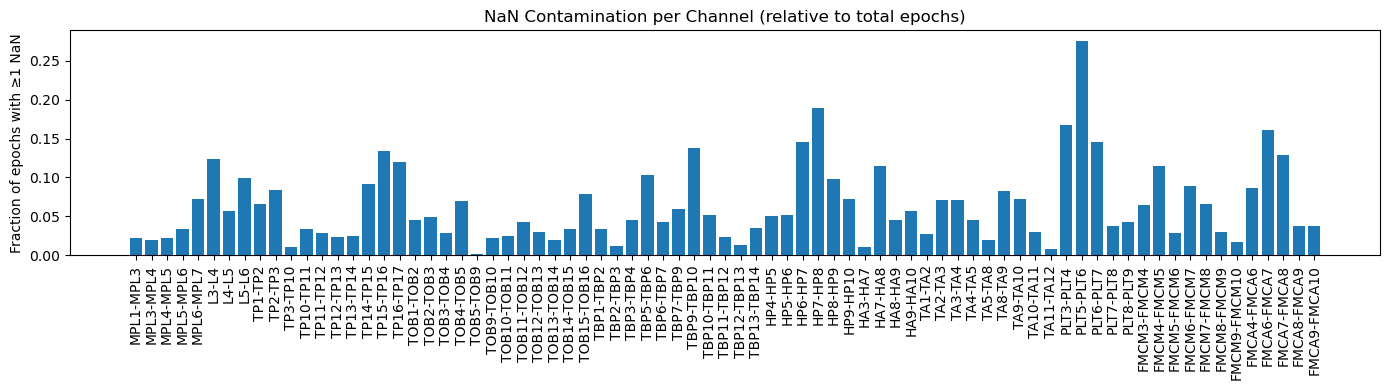

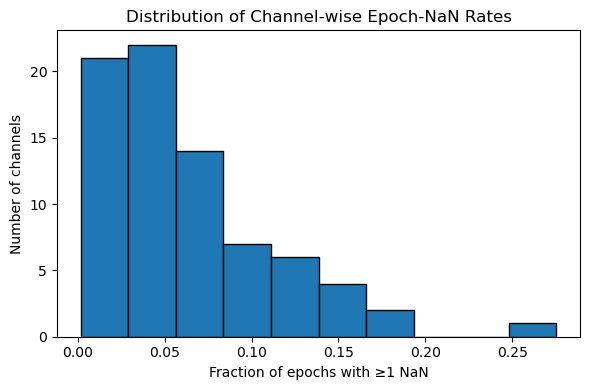

In [70]:
data = epochs.get_data()           
nan_mask = np.isnan(data)
n_epochs, n_ch, _ = data.shape
ch_names = epochs.ch_names

epoch_chan_nan  = np.any(nan_mask, axis=2).sum(axis=0)

frac_bad_epochs = epoch_chan_nan / n_epochs

plt.figure(figsize=(14,4))
plt.bar(ch_names, frac_bad_epochs)
plt.xticks(rotation=90)
plt.ylabel('Fraction of epochs with ≥1 NaN')
plt.title('NaN Contamination per Channel (relative to total epochs)')
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.hist(frac_bad_epochs, bins=10, edgecolor='k')
plt.xlabel('Fraction of epochs with ≥1 NaN')
plt.ylabel('Number of channels')
plt.title('Distribution of Channel‐wise Epoch‐NaN Rates')
plt.tight_layout()

plt.show()


In [71]:
threshold = 0.055
bad_ch = [ch for i, ch in enumerate(ch_names) if frac_bad_epochs[i] > threshold]
print(f"Dropping channels with >{threshold*100:.0f}% bad epochs:", bad_ch)

epochs_clean = epochs.copy().drop_channels(bad_ch)

print(f"→ Channels before: {len(ch_names)}")
print(f"→ Channels after : {len(epochs_clean.ch_names)}")

Dropping channels with >6% bad epochs: ['MPL6-MPL7', 'L3-L4', 'L4-L5', 'L5-L6', 'TP1-TP2', 'TP2-TP3', 'TP14-TP15', 'TP15-TP16', 'TP16-TP17', 'TOB4-TOB5', 'TOB15-TOB16', 'TBP5-TBP6', 'TBP7-TBP9', 'TBP9-TBP10', 'HP6-HP7', 'HP7-HP8', 'HP8-HP9', 'HP9-HP10', 'HA7-HA8', 'HA9-HA10', 'TA2-TA3', 'TA3-TA4', 'TA8-TA9', 'TA9-TA10', 'PLT3-PLT4', 'PLT5-PLT6', 'PLT6-PLT7', 'FMCM3-FMCM4', 'FMCM4-FMCM5', 'FMCM6-FMCM7', 'FMCM7-FMCM8', 'FMCA4-FMCA6', 'FMCA6-FMCA7', 'FMCA7-FMCA8']
→ Channels before: 77
→ Channels after : 43


In [72]:
data_clean_ch = epochs_clean.get_data()           

nan_mask2 = np.isnan(data_clean_ch)

epoch_has_nan2 = np.any(nan_mask2, axis=(1,2))  

n_epochs_with_nan2 = np.sum(epoch_has_nan2)
n_total_epochs = len(epochs_clean)

print(f"{n_epochs_with_nan2} out of {n_total_epochs} epochs contain at least one NaN in the remaining channels")

bad_epoch_indices2 = np.where(epoch_has_nan2)[0]
print("Bad epoch indices:", bad_epoch_indices2.tolist())


243 out of 592 epochs contain at least one NaN in the remaining channels
Bad epoch indices: [2, 5, 6, 7, 8, 9, 10, 14, 19, 24, 30, 37, 40, 42, 43, 44, 47, 48, 49, 50, 54, 61, 63, 68, 69, 70, 71, 78, 82, 83, 90, 96, 101, 102, 108, 109, 110, 112, 118, 119, 123, 125, 128, 135, 137, 157, 162, 167, 177, 178, 185, 186, 187, 190, 193, 196, 197, 199, 200, 202, 205, 206, 207, 208, 214, 220, 221, 228, 229, 230, 232, 233, 234, 237, 239, 243, 245, 248, 255, 259, 276, 277, 278, 279, 282, 288, 289, 292, 295, 298, 299, 301, 305, 309, 313, 321, 322, 324, 325, 326, 327, 329, 330, 331, 335, 336, 337, 338, 339, 340, 345, 349, 350, 352, 353, 358, 360, 361, 362, 363, 365, 366, 369, 370, 371, 373, 376, 377, 378, 381, 384, 385, 386, 387, 388, 389, 390, 396, 397, 400, 410, 413, 415, 417, 418, 419, 422, 424, 425, 426, 429, 433, 435, 438, 441, 442, 445, 450, 453, 458, 459, 460, 461, 462, 464, 465, 466, 467, 469, 471, 473, 476, 477, 478, 479, 480, 481, 482, 485, 489, 492, 493, 494, 495, 496, 499, 502, 504, 505, 

In [73]:
good_epochs = np.where(~epoch_has_nan2)[0]
print(f"Keeping {len(good_epochs)} / {len(epochs_clean)} epochs")

epochs_no_nans = epochs_clean[good_epochs]

Keeping 349 / 592 epochs


In [74]:
epochs_path = os.path.join(preproc_dir, "epochs_s06prior_cleaned-epo.fif")
epochs_no_nans.save(epochs_path, overwrite=True)

[PosixPath('/archive/intracranial/Exp_3_WM_prior/Preproc/s06/epochs_s06prior_cleaned-epo.fif')]

# Dummy data

In [ ]:
sfreq = 1000  
duration = 5  
n_samples = sfreq * duration
n_channels = 2

time = np.arange(n_samples) / sfreq

data = 0.5 * np.sin(2 * np.pi * 10 * time)[None, :] \
       + 0.05 * np.random.randn(n_channels, n_samples)

data[0, sfreq:sfreq+100] += 2 * np.random.randn(100)

data[1, 3*sfreq:3*sfreq+50] += 1 * np.random.randn(50)

start = int(2 * sfreq)
end = start + int(0.2 * sfreq)

data[0, start:end] = 0.5 * np.sin(2 * np.pi * 30 * time[start:end]) \
                    + 0.05 * np.random.randn(end - start)


# Autoreject

In [75]:
epochs_autoreject = epochs_raw.copy()

In [76]:
epochs_autoreject.metadata = all_df

Replacing existing metadata with 31 columns


In [77]:
from autoreject import get_rejection_threshold, AutoReject, RejectLog

In [78]:
reject_threshold = get_rejection_threshold(epochs_autoreject)
print("Per-channel flat & peak-to-peak thresholds:", reject_threshold)

Estimating rejection dictionary for seeg
Per-channel flat & peak-to-peak thresholds: {'seeg': 0.0023639187229990166}


In [79]:
epochs_autoreject.drop_bad(reject = reject_threshold)

0 bad epochs dropped


<Epochs | 600 events (all good), -1.5 – 4.5 s (baseline -1.5 – 0 s), ~1.10 GiB, data loaded, with metadata,
 'FP_Main': 600>

In [80]:
picks_epochs = mne.pick_types(
    epochs_autoreject.info,
    seeg=True,
    exclude='bads'
)

In [81]:
ar = AutoReject(n_interpolate=[0], consensus=[0.3], picks=picks_epochs, verbose=True)
epochs_clean = ar.fit_transform(epochs_autoreject)  # returns a NumPy array of shape (n_epochs, n_channels, n_times)

Running autoreject on ch_type=seeg


  0%|          | Creating augmented epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/82 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=0


  0%|          | Repairing epochs : 0/600 [00:00<?,       ?it/s]

Dropped 64 epochs: 6, 8, 9, 32, 36, 39, 41, 42, 44, 50, 72, 105, 127, 166, 224, 225, 234, 239, 242, 281, 286, 300, 307, 313, 317, 318, 327, 332, 333, 338, 344, 346, 360, 366, 379, 381, 386, 392, 394, 395, 398, 450, 453, 466, 467, 475, 481, 485, 489, 504, 520, 527, 533, 540, 541, 542, 546, 550, 551, 552, 554, 555, 576, 585


In [82]:
reject_log = ar.get_reject_log(epochs_autoreject)

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using matplotlib as 2D backend.


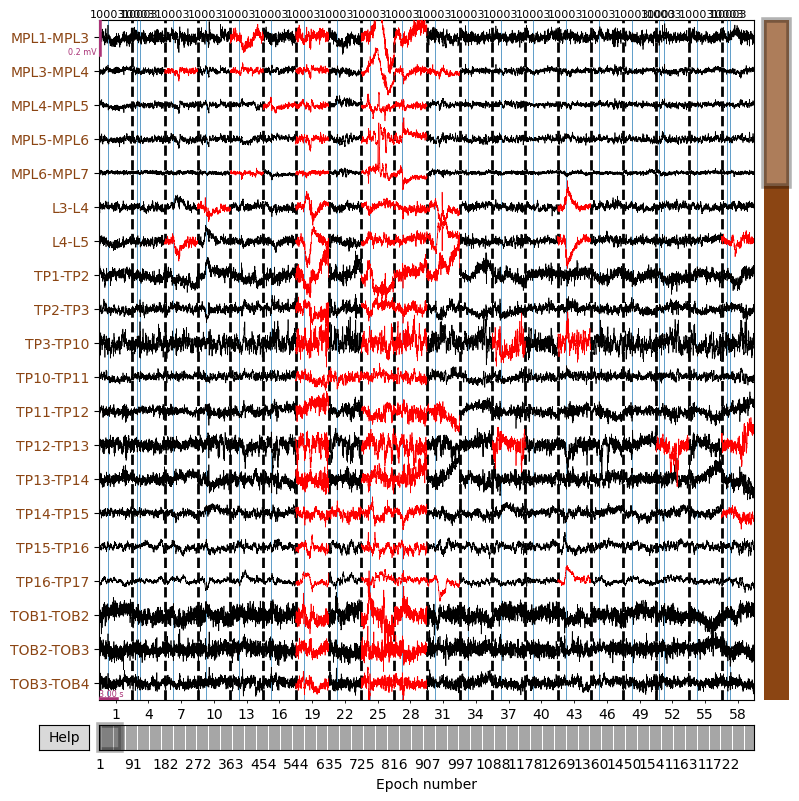

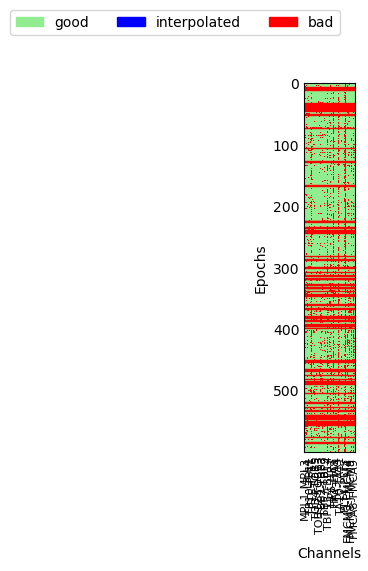

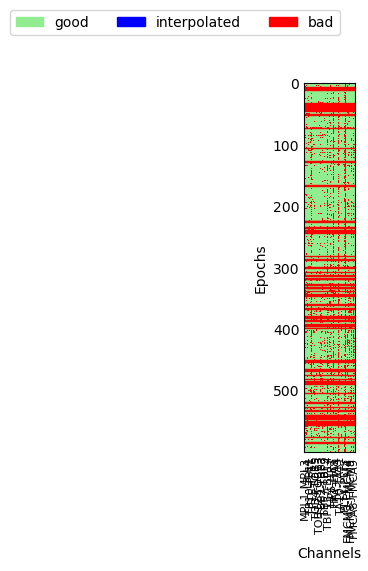

In [83]:
reject_log.plot_epochs(epochs_autoreject, scalings=1e-4)       
reject_log.plot()    

In [84]:
good_mask = ~reject_log.bad_epochs  
epochs_clean_mne = epochs_autoreject[good_mask].copy()
epochs_clean_mne.metadata = all_df.iloc[good_mask].reset_index(drop=True)

Replacing existing metadata with 31 columns


In [85]:
import json

Overwriting existing file.


Overwriting existing file.


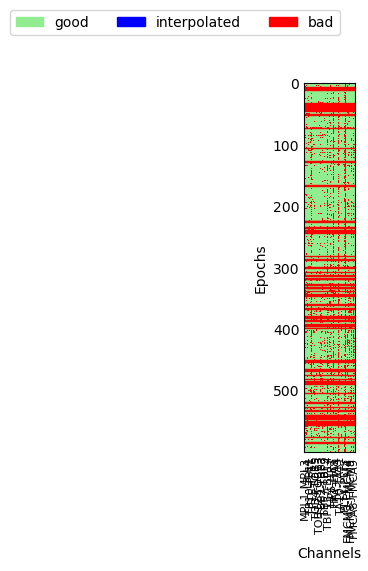

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


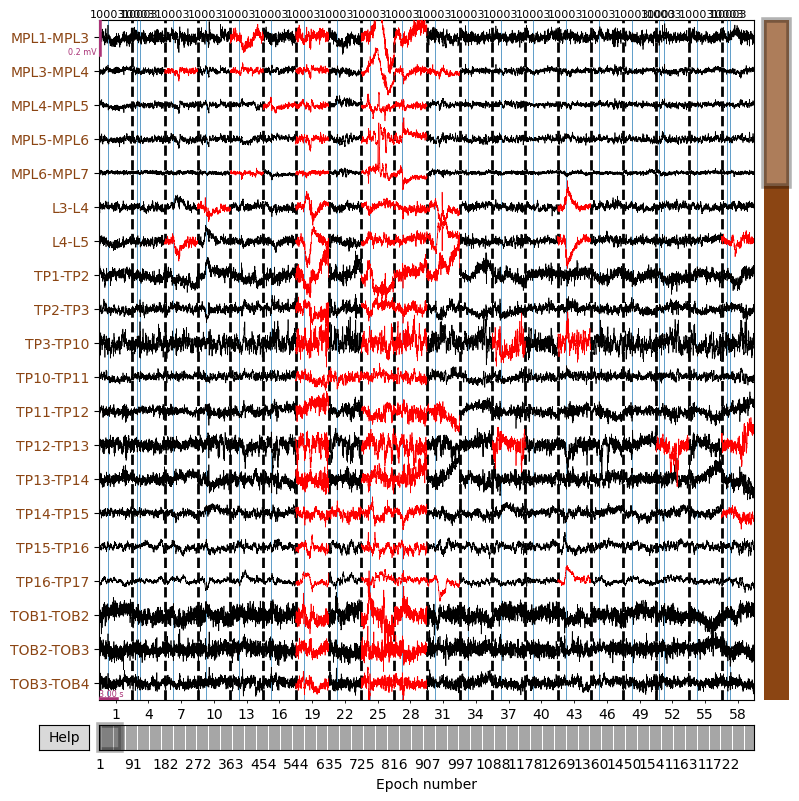

In [86]:
out_dir = '/archive/intracranial/Exp_3_WM_prior/Preproc/s06/autoreject'
os.makedirs(out_dir, exist_ok=True)

with open(os.path.join(out_dir, 'reject_threshold.json'), 'w') as f:
    json.dump(reject_threshold, f, indent=2)

epochs_autoreject.save(os.path.join(out_dir, 'epochs_autoreject-dropped-epo.fif'), overwrite=True)

epochs_clean_mne.save('autoreject_epochs_s06-epo.fif', overwrite=True)

#np.save(os.path.join(out_dir, 'epochs_clean.npy'), epochs_clean)

with open(os.path.join(out_dir, 'autoreject_model.pkl'), 'wb') as f:
    pickle.dump(ar, f)

with open(os.path.join(out_dir, 'reject_log.pkl'), 'wb') as f:
    pickle.dump(reject_log, f)

fig1 = reject_log.plot() 
fig1.savefig(os.path.join(out_dir, 'reject_log_summary.png'), dpi=150)

fig2 = reject_log.plot_epochs(epochs_autoreject, scalings=1e-4)
fig2.savefig(os.path.join(out_dir, 'reject_log_epochs.png'), dpi=150)
